In [1]:
import importlib, baysian_tuning, pytorch_simple
importlib.reload(pytorch_simple)
importlib.reload(baysian_tuning)

import pandas as pd
import numpy as np

import importlib
import pytorch_simple
importlib.reload(pytorch_simple)

from pytorch_simple import PytorchRegressor

import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor


from sklearn.metrics import mean_squared_error, accuracy_score, f1_score


from baysian_tuning import Objective
import optuna

In [2]:
FACTORS_2 = ['DELTA', 'SPY_LOG_RET']
FACTORS_3 = ['DELTA', 'DTE', 'SPY_LOG_RET']
FACTORS_4 = ['DELTA', 'DTE', 'SPY_LOG_RET', 'VIX']

TARGET = 'IV_DELTA'

In [3]:
def plot_importance(model, features):
    
    model.importance_type = 'total_gain'

    # Sort features and importances
    sorted_idx = np.argsort(model.feature_importances_)
    sorted_factors = np.array(features)[sorted_idx]
    sorted_importances = np.array(model.feature_importances_)[sorted_idx]

    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    bars = plt.barh(sorted_factors, sorted_importances, color='skyblue')

    # Add values to the bars
    for bar in bars:
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
                f'{bar.get_width():.4f}', va='center', ha='left', fontsize=12)

    # Customize the plot
    plt.xlabel('Absolute Gain', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title('Absolute Gain Feature Importance', fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Invert y-axis to have the most important feature at the top
    plt.gca().invert_yaxis()

    # Adjust layout for better appearance
    plt.tight_layout()

    # Show plot
    plt.show()
    
def r_square(df: pd.DataFrame, pred_col):
    return 1 - mean_squared_error(df[TARGET], df[pred_col]) / mean_squared_error(df[TARGET], np.full(len(df), df[TARGET].mean()))



def calculate_gain(df, model_a, model_b):
    
    return 1 - mean_squared_error(df[TARGET], df[model_a]) / mean_squared_error(df[TARGET], df[model_b])
    

### 3. Data
We used S&P 500 call options data from OptionMetrics between January 2010 and December 2017. The data for each option on each day includes the strike price, time to maturity, index level, and implied volatility, as well as hedge parameters such as delta, gamma, vega, and theta derived from the practitioner Black-Scholes model.


The data was filtered in a number of ways. We only retained options where the information provided was complete. Options with remaining lives less than 14 days were removed from the data set. Options for which the practitioner Black-Scholes delta was less than 0.05 or greater than 0.95 were removed from the data set. The data was then sorted to produce observations for the same option on two successive trading days. This resulted in about 2.07 million observations on daily volatility changes for 53,653 call options.


The three features we used in the first stage of this research are the S&P 500 daily change, time-to-maturity, and the practitioner Black-Scholes delta. There is one target, the implied volatility change. In the second stage we added the VIX index as a feature. A summary of statistical properties of the features and target variables is provided in Table 1.

To apply the neural network technique, we randomly divided the data into a training set, a validation set, and test set, with a 7:2:1 ratio. We used the training set and the validation set to train and fine-tune the neural network model, and then evaluated the model performance with the test set. All results presented are those for the test set.


### 4. Model Selection Criteria
Key elements of a neural network model are the activation function, the number of layers and the number of nodes per layer. The activation functions fi in equation (1) for i ≤ n are designed
10
to distinguish between positive and negative signals. We considered four different activation
functions that have been suggested in the literature: the sigmoid, the rectified linear unit (relu),
the leaky relu, and the exponential linear unit. The functional forms are shown in Table 2.
They all have attractive properties for backpropagation algorithms. For i = n+1 the activation
function is f(x) = x so that a linear function relates values at the nodes on the final hidden
layer to the target. (This is usual practice when a continuous variable is being estimated.) We
present results for a model with three hidden layers and 80 nodes per layer. We found models
with sigmoid activation functions generally perform better (lower mean squared errors) and
we will therefore only present results from using the sigmoid activation function.


To avoid overfitting, we experimented with a number of different early stopping rules. A
common approach involves stopping when the mean square error for the validation set starts
to trend up. For our data this happened only after a very large number of epochs if at all, a
result which may be indicative of local overfitting.

In the end, we decided to use the
smoothness of the predicted change in the volatility surface as our criterion. We manually
inspected a three-dimensional plot of the volatility surface change as the number of epochs
was increased and stopped when this was no longer smooth. This led to earlier stopping than
that would be indicated by other rules. In both of the three-factor models and four-factor
model we stopped after 4,000 epochs. The choice of the stopping rule did not affect the
general shape of the volatility surface movements, but it did affect the smoothness of the
results.

In [4]:
data = pd.read_parquet('datasets/option_dataset.parquet.gzip')
data = data.dropna(subset=['SPY_LOG_RET', 'DELTA', 'DTE'])
to_drop = pd.read_pickle('to_drop')
data = data[~data.index.isin(to_drop)]
data = data[data['DELTA'] > 0]

In [5]:
data['DTE'].value_counts()

DTE
21.00     5814
28.00     5377
22.00     5307
23.00     5107
24.00     5060
          ... 
3.04         1
523.04       1
789.04       1
747.00       1
809.00       1
Name: count, Length: 2069, dtype: int64

# Loading Data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 427799 entries, 0 to 438015
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   QUOTE_DATE       427799 non-null  object  
 1   option_id        427799 non-null  category
 2   EXPIRE_UNIX      427799 non-null  int64   
 3   STRIKE           427799 non-null  float64 
 4   IV               427799 non-null  float64 
 5   DELTA            427799 non-null  float64 
 6   DTE              427799 non-null  float64 
 7   MID              427799 non-null  float64 
 8   UNDERLYING_LAST  427799 non-null  float64 
 9   BidAskSpread     427799 non-null  float64 
 10  VOLUME           427799 non-null  float64 
 11  IV_DELTA         427799 non-null  float64 
 12  IV_LOG_RET       427799 non-null  float64 
 13  VIX              427799 non-null  float64 
 14  1Y_US            424462 non-null  float64 
 15  SPY_LOG_RET      427799 non-null  float64 
dtypes: category(1), float64(1

In [7]:
cols = ['option_id', 'STRIKE', 'IV', 'DELTA', 'DTE', 'SPY_LOG_RET', 'VIX', 'IV_DELTA']

In [8]:
data['EXPIRE_DATE'] = pd.to_datetime(data['EXPIRE_UNIX'], unit='s').dt.date

In [9]:
cols = ['EXPIRE_DATE', 'STRIKE', 'IV', 'DELTA', 'DTE', 'SPY_LOG_RET', 'VIX', 'IV_DELTA']

In [15]:
data.loc[data['QUOTE_DATE'] == '2018-02-05', :].sort_values(['EXPIRE_DATE', 'STRIKE'])[cols].head(10).to_latex('latex.txt')

In [11]:
# with open('latex.txt', 'w') as f:
#     f.write(data.loc[data['QUOTE_DATE'] == '2018-02-05', :].sort_values(['EXPIRE_DATE', 'STRIKE'])[cols].head(10).to_latex(index=False, caption='10 Saples for day 2018-02-05', float_format="%.4f"))

# Inspect Dataset

In [12]:
data

,QUOTE_DATE,option_id,EXPIRE_UNIX,STRIKE,IV,DELTA,DTE,MID,UNDERLYING_LAST,BidAskSpread,VOLUME,IV_DELTA,IV_LOG_RET,VIX,1Y_US,SPY_LOG_RET,EXPIRE_DATE
0,2010-01-04,C_20100115_109.0,1263589200,109.0,0.21782,0.83985,11.0,4.630,113.29,0.008639,189.0,-0.02621,-0.128207,20.04,0.45,0.016818,2010-01-15
1,2010-01-22,C_20100219_100.0,1266613200,100.0,0.32457,0.84393,28.0,10.080,109.22,0.013889,310.0,0.00302,0.009262,27.31,0.30,-0.022544,2010-02-19
2,2010-01-22,C_20100219_101.0,1266613200,101.0,0.31677,0.82168,28.0,9.195,109.22,0.009788,153.0,0.00070,0.002207,27.31,0.30,-0.022544,2010-02-19
3,2010-01-25,C_20100219_101.0,1266613200,101.0,0.31747,0.84464,25.0,9.480,109.78,0.016878,78.0,-0.01361,-0.043816,25.41,0.30,0.005115,2010-02-19
5,2010-01-22,C_20100219_102.0,1266613200,102.0,0.30291,0.80021,28.0,8.300,109.22,0.012048,137.0,0.00230,0.007564,27.31,0.30,-0.022544,2010-02-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438011,2019-12-26,C_20221216_270.0,1671224400,270.0,0.22702,0.71808,1086.0,70.135,322.94,0.060883,71.0,0.00185,0.008116,12.65,1.53,0.005309,2022-12-16
438012,2019-12-27,C_20221216_300.0,1671224400,300.0,0.20876,0.60934,1085.0,49.895,322.85,0.071550,30.0,0.00007,0.000335,13.43,1.51,-0.000248,2022-12-16
438013,2019-12-23,C_20221216_320.0,1671224400,320.0,0.19685,0.52760,1089.0,38.130,321.27,0.032520,22.0,-0.00158,-0.008059,12.61,1.53,0.001527,2022-12-16
438014,2019-12-27,C_20221216_325.0,1671224400,325.0,0.19248,0.50798,1085.0,35.405,322.85,0.079367,150.0,0.00126,0.006525,13.43,1.51,-0.000248,2022-12-16


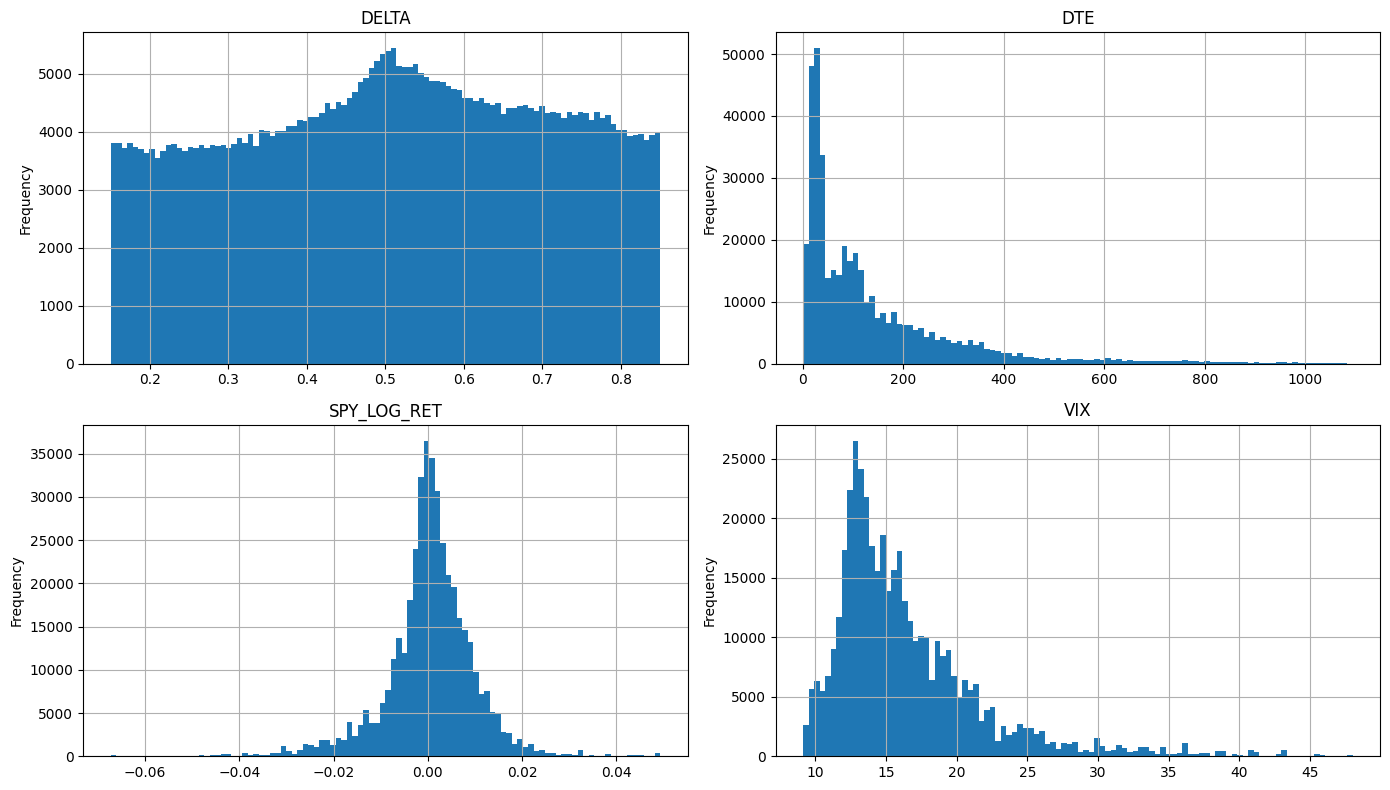

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
axes = axes.flatten()

for ax, feat in zip(axes, FACTORS_4):
    data[feat].plot(kind='hist', bins=100, grid=True, title=feat, ax=ax)    

fig.tight_layout()

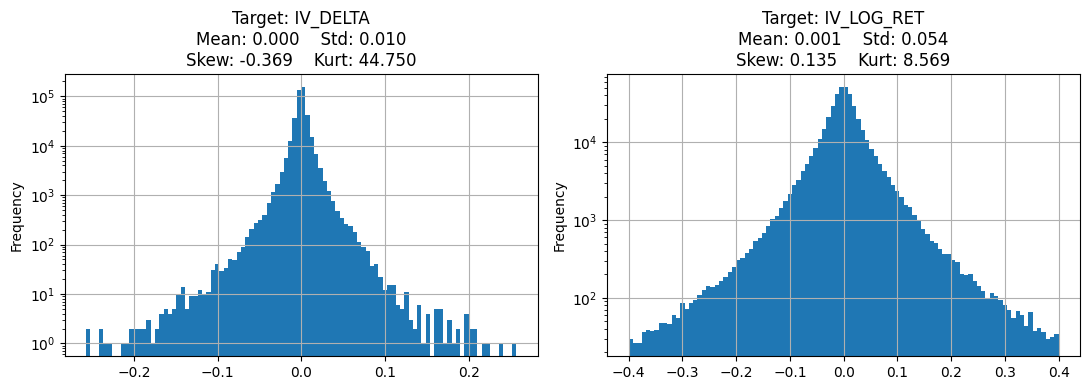

In [29]:
from scipy.stats import jarque_bera
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
axes = axes.flatten()

for ax, feat in zip(axes, ['IV_DELTA', 'IV_LOG_RET']):
    mean = data[feat].mean()
    std = data[feat].std()
    skewness = data[feat].skew()
    kurtosis = data[feat].kurtosis()
    data[feat].plot(kind='hist', bins=100, grid=True, title=f'Target: {feat}\nMean: {mean:0.03f}    Std: {std:0.03f}\nSkew: {skewness:0.03f}    Kurt: {kurtosis:0.03f}', ax=ax, log=True)

fig.tight_layout()

# Train Test Splitting

In [62]:
train_test = data[data['EXPIRE_UNIX'] < pd.to_datetime('2019-05-01').timestamp()]
valid = data.drop(train_test.index)

In [ ]:
train = train_test.sample(frac=0.7, replace=False, random_state=3)
test = train_test.drop(train.index)

In [ ]:
len(train_test), len(test), len(valid)

### NOTE

The Validation set is the last half year of our data, we didnt shuffle that set and made sure that there is no data leakage. Later we use that to prove that shuffeling the datasets introduces data leakage

In [82]:
train

,QUOTE_DATE,option_id,EXPIRE_UNIX,STRIKE,IV,DELTA,DTE,MID,UNDERLYING_LAST,BidAskSpread,VOLUME,IV_DELTA,IV_LOG_RET,VIX,1Y_US,SPY_LOG_RET,nn_3factors,nn_4factors,xgb3,xgb4
33736,2011-12-14,C_20120120_112.0,1327093200,112.0,0.28089,1.700603,-0.637479,10.330,121.74,0.011617,358.0,-0.02221,-0.082371,1.846414,0.12,-1.168982,0.000723,-0.012632,-0.007249,-0.010626
33794,2011-12-14,C_20120120_113.0,1327093200,113.0,0.27800,1.553686,-0.637479,9.500,121.74,0.014737,601.0,-0.01916,-0.071411,1.846414,0.12,-1.168982,0.000138,-0.011898,-0.007528,-0.014182
36610,2011-12-14,C_20120217_108.0,1329512400,108.0,0.31780,1.644867,-0.475281,14.880,121.74,0.013441,122.0,-0.01619,-0.052287,1.846414,0.12,-1.168982,0.000182,-0.007687,-0.005318,-0.007230
36631,2011-12-14,C_20120217_110.0,1329512400,110.0,0.31115,1.469543,-0.475281,13.225,121.74,0.015879,202.0,-0.01565,-0.051606,1.846414,0.12,-1.168982,-0.000461,-0.006159,-0.005248,-0.007224
36648,2011-12-14,C_20120217_111.0,1329512400,111.0,0.30406,1.380520,-0.475281,12.375,121.74,0.012121,157.0,-0.01188,-0.039855,1.846414,0.12,-1.168982,-0.000770,-0.005396,-0.003721,-0.007224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54414,2010-02-22,C_20121221_115.0,1356123600,115.0,0.20626,-0.051201,5.132132,12.485,111.13,0.021626,25.0,0.00062,0.003001,0.672910,0.37,-0.024931,-0.000325,-0.000557,-0.000053,-0.000402
54692,2010-02-22,C_20121221_120.0,1356123600,120.0,0.20162,-0.327466,5.132132,10.370,111.13,0.023144,370.0,-0.00059,-0.002931,0.672910,0.37,-0.024931,-0.000318,-0.000507,-0.000058,-0.000693
55105,2010-02-22,C_20121221_125.0,1356123600,125.0,0.19497,-0.606197,5.132132,8.410,111.13,0.030916,349.0,-0.00025,-0.001283,0.672910,0.37,-0.024931,-0.000310,-0.000460,-0.000121,-0.000682
58501,2010-02-22,C_20121221_150.0,1356123600,150.0,0.16964,-1.803569,5.132132,2.320,111.13,0.051724,180.0,0.00091,0.005350,0.672910,0.37,-0.024931,-0.000280,-0.000144,-0.000139,0.000076


In [26]:
target_mean = train[TARGET].mean()

# Benchmark Factor model

In [ ]:
import numpy as np

def model_func(coeffs, spy_ret, delta, dtm, y):
    a, b, c = coeffs
    y_pred = spy_ret * (a + b*delta + c*delta**2) / np.sqrt(dtm)
    return y_pred - y

def predict_(coeffs, spy_ret, delta, dtm):
    a, b, c = coeffs
    return spy_ret * (a + b*delta + c*delta**2) / np.sqrt(dtm)


In [ ]:
from scipy.optimize import least_squares

# Initial guess for coefficients
initial_guess = [1.0, 1.0, 1.0]

# Data
spy_ret = train['SPY_LOG_RET'].to_numpy() # array of x1 values
delta = train['DELTA'].to_numpy()  # array of x2 values
dtm = train['DTE'].to_numpy()  # array of x3 values
y = train[TARGET].to_numpy()    # array of corresponding y values

# Perform optimization
result = least_squares(model_func, initial_guess, args=(spy_ret, delta, dtm, y))

In [ ]:
COEFS = result['x']

In [ ]:
train['linear_pred'] = predict_(COEFS, train['SPY_LOG_RET'], train['DELTA'], train['DTE'])
test['linear_pred'] = predict_(COEFS, test['SPY_LOG_RET'], test['DELTA'], test['DTE'])
valid['linear_pred'] = predict_(COEFS, valid['SPY_LOG_RET'], valid['DELTA'], valid['DTE'])

# Neural Network

### Data Scaling

In [ ]:
# std scaling
from sklearn.preprocessing import StandardScaler

sclr = StandardScaler()

train[FACTORS_4] = sclr.fit_transform(train[FACTORS_4])
test[FACTORS_4] = sclr.transform(test[FACTORS_4])
valid[FACTORS_4] = sclr.transform(valid[FACTORS_4])

In [63]:
# read_saved data
train = pd.read_pickle('replication_dataframes/train.pkl')
test = pd.read_pickle('replication_dataframes/test.pkl')
valid = pd.read_pickle('replication_dataframes/valid.pkl')

### 2 Feature Neural Network

In [4]:
from torch import nn

params = {
    'depth': 3,
    'width': 150,
    'learning_rate': 0.00015,
    'batchnorm': False,
    'drop_out_rate': 0.01,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 500,
    'early_stopping_rounds': 30,
    'device': 'cpu',
    'scheduler_rate': 0.995
}


nn_2 = PytorchRegressor(**params)

In [7]:
nn_2.fit(train[FACTORS_2].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_2].to_numpy(), test[TARGET].to_numpy())])
pd.to_pickle(nn_2, '2feature.model')

Epoch_1 Train_loss: 0.00014128566663352044, Val_loss: 0.0001053163141477853
Epoch_2 Train_loss: 0.0001041208930827914, Val_loss: 9.923689503921196e-05
Epoch_3 Train_loss: 0.00010094022946577752, Val_loss: 9.795121877687052e-05
Epoch_4 Train_loss: 9.966516624227239e-05, Val_loss: 9.86805243883282e-05
Epoch_5 Train_loss: 9.950817935950014e-05, Val_loss: 9.77713571046479e-05
Epoch_6 Train_loss: 9.926338175721524e-05, Val_loss: 9.786940790945664e-05
Epoch_7 Train_loss: 9.913114253647452e-05, Val_loss: 9.80675540631637e-05
Epoch_8 Train_loss: 9.898731978987076e-05, Val_loss: 9.917160787153989e-05
Epoch_9 Train_loss: 9.884454502282066e-05, Val_loss: 9.805612353375182e-05
Epoch_10 Train_loss: 9.88486937024644e-05, Val_loss: 9.74924914771691e-05
Epoch_11 Train_loss: 9.899655774321129e-05, Val_loss: 9.759582462720573e-05
Epoch_12 Train_loss: 9.883703088333456e-05, Val_loss: 9.795761434361339e-05
Epoch_13 Train_loss: 9.864685544016538e-05, Val_loss: 9.777965897228569e-05
Epoch_14 Train_loss: 9.8

In [10]:
train['nn_2factors'] = nn_2.predict(train[FACTORS_2].to_numpy())
test['nn_2factors'] = nn_2.predict(test[FACTORS_2].to_numpy())
valid['nn_2factors'] = nn_2.predict(valid[FACTORS_2].to_numpy())

### 3 Feature Neural Network

In [ ]:
from torch import nn

params = {
    'depth': 3,
    'width': 150,
    'learning_rate': 0.00015,
    'batchnorm': False,
    'drop_out_rate': 0.01,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 500,
    'early_stopping_rounds': 30,
    'device': 'cpu',
    'scheduler_rate': 0.995
}


nn_3 = PytorchRegressor(**params)

In [ ]:
nn_3.fit(train[FACTORS_3].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_3].to_numpy(), test[TARGET].to_numpy())])
pd.to_pickle(nn_3, '3feature.model')

In [ ]:
train['nn_3factors'] = nn_3.predict(train[FACTORS_3].to_numpy())
test['nn_3factors'] = nn_3.predict(test[FACTORS_3].to_numpy())
valid['nn_3factors'] = nn_3.predict(valid[FACTORS_3 ].to_numpy())

### 4 Feature Neural Network

In [ ]:
from torch import nn

params = {
    'depth': 3,
    'width': 150,
    'learning_rate': 0.00015,
    'batchnorm': False,
    'drop_out_rate': 0.01,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 500,
    'early_stopping_rounds': 30,
    'device': 'cpu',
    'scheduler_rate': 0.995
}


nn_4 = PytorchRegressor(**params)

In [ ]:
nn_4.fit(train[FACTORS_4].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_4].to_numpy(), test[TARGET].to_numpy())])
pd.to_pickle(nn_4, '4feature_v2.model')

In [ ]:
train['nn_4factors'] = nn_4.predict(train[FACTORS_4].to_numpy())
test['nn_4factors'] = nn_4.predict(test[FACTORS_4].to_numpy())
valid['nn_4factors'] = nn_4.predict(valid[FACTORS_4 ].to_numpy())

# Xgboost

In [11]:
from xgboost import XGBRegressor

In [13]:
model2 = XGBRegressor()

model2.fit(train[FACTORS_2], train[TARGET])
train['xgb2'] = model2.predict(train[FACTORS_2])
test['xgb2'] = model2.predict(test[FACTORS_2])
valid['xgb2'] = model2.predict(valid[FACTORS_2])

In [ ]:
model3 = XGBRegressor()

model3.fit(train[FACTORS_3], train[TARGET])
train['xgb3'] = model3.predict(train[FACTORS_3])
test['xgb3'] = model3.predict(test[FACTORS_3])
valid['xgb3'] = model3.predict(valid[FACTORS_3])

In [14]:
model4 = XGBRegressor()

model4.fit(train[FACTORS_4], train[TARGET])
train['xgb4'] = model4.predict(train[FACTORS_4])
test['xgb4'] = model4.predict(test[FACTORS_4])
valid['xgb4'] = model4.predict(valid[FACTORS_4])

In [20]:
train['Noise'] = np.random.normal(size=(len(train)))
test['Noise'] = np.random.normal(size=(len(test)))
valid['Noise'] = np.random.normal(size=(len(valid)))
FACTORS_5 = FACTORS_4 + ['Noise']

model5 = XGBRegressor()

model5.fit(train[FACTORS_5], train[TARGET])
train['xgb5'] = model5.predict(train[FACTORS_5])
test['xgb5'] = model5.predict(test[FACTORS_5])
valid['xgb5'] = model5.predict(valid[FACTORS_5])

### Plot Feature Importance

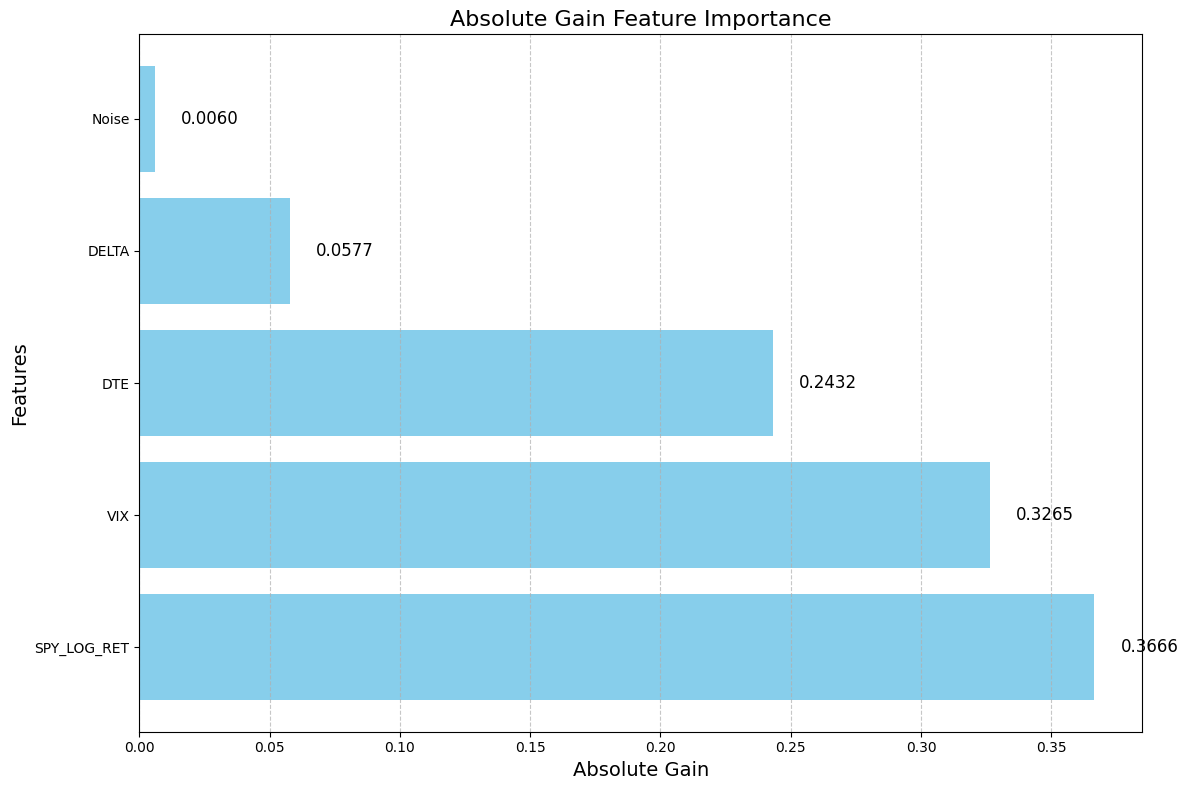

In [22]:
plot_importance(model5, FACTORS_5)

### Save Replication Data

In [31]:
train.to_pickle('replication_dataframes/train.pkl')
test.to_pickle('replication_dataframes/test.pkl')
valid.to_pickle('replication_dataframes/valid.pkl')

# Results

### Test Set

In [66]:
print('=== MSE ===')
print('Benchmark:', mean_squared_error(test[TARGET], test['linear_pred']))
print('NN_2:', mean_squared_error(test[TARGET], test['nn_2factors']))
print('NN_3:', mean_squared_error(test[TARGET], test['nn_3factors']))
print('NN_4:', mean_squared_error(test[TARGET], test['nn_4factors']))
print('XGB_2:', mean_squared_error(test[TARGET], test['xgb2']))
print('XGB_3:', mean_squared_error(test[TARGET], test['xgb3']))
print('XGB_4:', mean_squared_error(test[TARGET], test['xgb4']))

print('=== Gain over Benchmark ===')
print('NN_2:', calculate_gain(test, 'nn_2factors', 'linear_pred'))
print('NN_3:', calculate_gain(test, 'nn_3factors', 'linear_pred'))
print('NN_4:', calculate_gain(test, 'nn_4factors', 'linear_pred'))
print('XGB_2:', calculate_gain(test, 'xgb2', 'linear_pred'))
print('XGB_3:', calculate_gain(test, 'xgb3', 'linear_pred'))
print('XGB_4:', calculate_gain(test, 'xgb4', 'linear_pred'))

print('=== R-Squared ===')
print('Benchmark:', r_square(test, 'linear_pred'))
print('NN_2:', r_square(test, 'nn_2factors'))
print('NN_3:', r_square(test, 'nn_3factors'))
print('NN_4:', r_square(test, 'nn_4factors'))
print('XGB_2:', r_square(test, 'xgb2'))
print('XGB_3:', r_square(test, 'xgb3'))
print('XGB_4:', r_square(test, 'xgb4'))

=== MSE ===
Benchmark: 0.00010188022380417244
NN_2: 9.27042288903854e-05
NN_3: 8.896219154036019e-05
NN_4: 5.511984666903816e-05
XGB_2: 9.309776121495986e-05
XGB_3: 6.684825780157088e-05
XGB_4: 3.4248413425385866e-05
=== Gain over Benchmark ===
NN_2: 0.09006649741390971
NN_3: 0.12679626900547902
NN_4: 0.4589740323403102
XGB_2: 0.08620380149629092
XGB_3: 0.34385442723347104
XGB_4: 0.6638364920436772
=== R-Squared ===
Benchmark: 0.0027929306585220415
NN_2: 0.0926078785904988
NN_3: 0.12923506647690952
NN_4: 0.4604850803524435
XGB_2: 0.08875597091473286
XGB_3: 0.34568699632010425
XGB_4: 0.6647753734113248


### Validation Set

In [65]:
print('=== MSE ===')
print('Benchmark:', mean_squared_error(valid[TARGET], valid['linear_pred']))
print('NN_2:', mean_squared_error(valid[TARGET], valid['nn_2factors']))
print('NN_3:', mean_squared_error(valid[TARGET], valid['nn_3factors']))
print('NN_4:', mean_squared_error(valid[TARGET], valid['nn_4factors']))
print('XGB_2:', mean_squared_error(valid[TARGET], valid['xgb2']))
print('XGB_3:', mean_squared_error(valid[TARGET], valid['xgb3']))
print('XGB_4:', mean_squared_error(valid[TARGET], valid['xgb4']))

print('=== Gain over Benchmark ===')
print('NN_2:', calculate_gain(valid, 'nn_2factors', 'linear_pred'))
print('NN_3:', calculate_gain(valid, 'nn_3factors', 'linear_pred'))
print('NN_4:', calculate_gain(valid, 'nn_4factors', 'linear_pred'))
print('XGB_2:', calculate_gain(valid, 'xgb2', 'linear_pred'))
print('XGB_3:', calculate_gain(valid, 'xgb3', 'linear_pred'))
print('XGB_4:', calculate_gain(valid, 'xgb4', 'linear_pred'))
print('=== R-Squared ===')

print('Benchmark:', r_square(valid, 'linear_pred'))
print('NN_2:', r_square(valid, 'nn_2factors'))
print('NN_3:', r_square(valid, 'nn_3factors'))
print('NN_4:', r_square(valid, 'nn_4factors'))
print('XGB_2:', r_square(valid, 'xgb2'))
print('XGB_3:', r_square(valid, 'xgb3'))
print('XGB_4:', r_square(valid, 'xgb4'))

=== MSE ===
Benchmark: 7.97971210854851e-05
NN_2: 8.513314689162278e-05
NN_3: 9.291031691280007e-05
NN_4: 0.00012166895158951415
XGB_2: 9.286203511524171e-05
XGB_3: 0.00011584241173589365
XGB_4: 0.00010249701782909527
=== Gain over Benchmark ===
NN_2: -0.06686990374529045
NN_3: -0.16433169077950893
NN_4: -0.5247285858743271
XGB_2: -0.16372663389397757
XGB_3: -0.45171166779054506
XGB_4: -0.2844701216638157
=== R-Squared ===
Benchmark: 0.04538600959989847
NN_2: -0.018448936052064102
NN_3: -0.11148732148432416
NN_4: -0.4555272396385954
XGB_2: -0.11090972571640778
XGB_3: -0.3858242680999189
XGB_4: -0.22617314839119884


# Redoing the Study 

In [17]:
FACTORS_2 = ['DELTA', 'SPY_LOG_RET']
FACTORS_3 = ['DELTA', 'DTE', 'SPY_LOG_RET']
FACTORS_4 = ['DELTA', 'DTE', 'SPY_LOG_RET', 'VIX']
FACTORS_5 = ['DELTA', 'DTE', 'SPY_LOG_RET', 'VIX', 'IV']

FACTORS_5_NOISE = FACTORS_5 + ['Noise']

TARGET = 'IV_DELTA'

In [18]:
def time_conscious_train_test_split(data: pd.DataFrame, train_size=0.7, test_size=0.2, grouping_col='QUOTE_DATE'):
    import random
    random.seed(42)
    
    grouped = [df for _, df in data.groupby(grouping_col)]

    random.shuffle(grouped)
    
    
    train_idx = int(len(grouped) * train_size)
    test_idx = int(len(grouped) * (train_size+test_size))
    

    train = pd.concat(grouped[:train_idx])
    test = pd.concat(grouped[train_idx:test_idx])
    valid = pd.concat(grouped[test_idx:])
    
    return train, test, valid

In [19]:
data = pd.read_parquet('datasets/option_dataset.parquet.gzip')
data = data.dropna(subset=['SPY_LOG_RET', 'DELTA', 'DTE'])
to_drop = pd.read_pickle('to_drop')
data = data[~data.index.isin(to_drop)]
data = data[data['DELTA'] > 0]

data['Noise'] = np.random.normal(size=(len(data)))

In [20]:
train, test, valid = time_conscious_train_test_split(data)

In [21]:
import numpy as np

def model_func(coeffs, spy_ret, delta, dtm, y):
    a, b, c = coeffs
    y_pred = spy_ret * (a + b*delta + c*delta**2) / np.sqrt(dtm)
    return y_pred - y

def predict_(coeffs, spy_ret, delta, dtm):
    a, b, c = coeffs
    return spy_ret * (a + b*delta + c*delta**2) / np.sqrt(dtm)

from scipy.optimize import least_squares

# Initial guess for coefficients
initial_guess = [1.0, 1.0, 1.0]

# Data
spy_ret = train['SPY_LOG_RET'].to_numpy() # array of x1 values
delta = train['DELTA'].to_numpy()  # array of x2 values
dtm = train['DTE'].to_numpy()  # array of x3 values
y = train[TARGET].to_numpy()    # array of corresponding y values

# Perform optimization
result = least_squares(model_func, initial_guess, args=(spy_ret, delta, dtm, y))
COEFS = result['x']
train['linear_pred'] = predict_(COEFS, train['SPY_LOG_RET'], train['DELTA'], train['DTE'])
test['linear_pred'] = predict_(COEFS, test['SPY_LOG_RET'], test['DELTA'], test['DTE'])
valid['linear_pred'] = predict_(COEFS, valid['SPY_LOG_RET'], valid['DELTA'], valid['DTE'])

In [22]:
# std scaling
from sklearn.preprocessing import StandardScaler

sclr = StandardScaler()

train[FACTORS_5] = sclr.fit_transform(train[FACTORS_5])
test[FACTORS_5] = sclr.transform(test[FACTORS_5])
valid[FACTORS_5] = sclr.transform(valid[FACTORS_5])

In [23]:
# read_saved data
# train = pd.read_pickle('our_approach_dataframes/train.pkl')
# test = pd.read_pickle('our_approach_dataframes/test.pkl')
# valid = pd.read_pickle('our_approach_dataframes/valid.pkl')


In [24]:
from torch import nn

params = {
    'depth': 2,
    'width': 30,
    'learning_rate': 0.00001,
    'batchnorm': False,
    'drop_out_rate': 0.05,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 500,
    'early_stopping_rounds': 3,
    'device': 'cpu',
    'scheduler_rate': 0.995
}


nn_2 = PytorchRegressor(**params)


nn_2.fit(train[FACTORS_2].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_2].to_numpy(), test[TARGET].to_numpy())])
pd.to_pickle(nn_2, '2feature.model')
train['nn_2factors'] = nn_2.predict(train[FACTORS_2].to_numpy())
test['nn_2factors'] = nn_2.predict(test[FACTORS_2].to_numpy())
valid['nn_2factors'] = nn_2.predict(valid[FACTORS_2].to_numpy())

Epoch_1 Train_loss: 0.007757644865934605, Val_loss: 0.0006636863690800965
Epoch_2 Train_loss: 0.00323299096678692, Val_loss: 0.00033316624467261136
Epoch_3 Train_loss: 0.0016863039229795174, Val_loss: 0.00019843112386297435
Epoch_4 Train_loss: 0.000867108455558714, Val_loss: 0.00013374126865528524
Epoch_5 Train_loss: 0.00044414881615491476, Val_loss: 0.00010526692494750023
Epoch_6 Train_loss: 0.00025344202068323105, Val_loss: 9.631869761506096e-05
Epoch_7 Train_loss: 0.0001676008406311192, Val_loss: 9.276444325223565e-05
Epoch_8 Train_loss: 0.00013049783314384193, Val_loss: 9.110727842198685e-05
Epoch_9 Train_loss: 0.00011459544381352354, Val_loss: 9.115697321249172e-05
Epoch_10 Train_loss: 0.00010737642890420645, Val_loss: 9.06398199731484e-05
Epoch_11 Train_loss: 0.00010395058947589528, Val_loss: 8.992374205263332e-05
Epoch_12 Train_loss: 0.0001020249408454776, Val_loss: 9.014122042572126e-05
Epoch_13 Train_loss: 0.00010142480101387606, Val_loss: 8.980821439763531e-05
Epoch_14 Train_

In [25]:
from torch import nn

params = {
    'depth': 2,
    'width': 30,
    'learning_rate': 0.00001,
    'batchnorm': False,
    'drop_out_rate': 0.05,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 500,
    'early_stopping_rounds': 4,
    'device': 'cpu',
    'scheduler_rate': 0.995
}


nn_3 = PytorchRegressor(**params)
nn_3.fit(train[FACTORS_3].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_3].to_numpy(), test[TARGET].to_numpy())])
train['nn_3factors'] = nn_3.predict(train[FACTORS_3].to_numpy())
test['nn_3factors'] = nn_3.predict(test[FACTORS_3].to_numpy())
valid['nn_3factors'] = nn_3.predict(valid[FACTORS_3].to_numpy())

Epoch_1 Train_loss: 0.017409098604646, Val_loss: 0.0012488754000514746
Epoch_2 Train_loss: 0.0019117030239364375, Val_loss: 0.00033515688846819103
Epoch_3 Train_loss: 0.0009377801473691733, Val_loss: 0.0001763304608175531
Epoch_4 Train_loss: 0.0004949240248388393, Val_loss: 0.00012045912444591522
Epoch_5 Train_loss: 0.0002753986586100526, Val_loss: 0.00010155294148717076
Epoch_6 Train_loss: 0.00017379610764682715, Val_loss: 9.454960672883317e-05
Epoch_7 Train_loss: 0.0001292004853516519, Val_loss: 9.079644951270893e-05
Epoch_8 Train_loss: 0.00011447014963255839, Val_loss: 8.950163464760408e-05
Epoch_9 Train_loss: 0.00010874495883454602, Val_loss: 8.91812305781059e-05
Epoch_10 Train_loss: 0.00010685585040593429, Val_loss: 8.853438339428976e-05
Epoch_11 Train_loss: 0.00010549652179473101, Val_loss: 8.920398249756545e-05
Epoch_12 Train_loss: 0.00010475069280570665, Val_loss: 8.859909576131031e-05
Epoch_13 Train_loss: 0.00010383598163989601, Val_loss: 8.89654693310149e-05
Early stopping at

In [26]:
from torch import nn

params = {
    'depth': 2,
    'width': 30,
    'learning_rate': 0.00001,
    'batchnorm': False,
    'drop_out_rate': 0.05,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 15,
    'early_stopping_rounds': 3,
    'device': 'cpu',
    'scheduler_rate': 0.995
}


nn_4 = PytorchRegressor(**params)
nn_4.fit(train[FACTORS_4].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_4].to_numpy(), test[TARGET].to_numpy())])
train['nn_4factors'] = nn_4.predict(train[FACTORS_4].to_numpy())
test['nn_4factors'] = nn_4.predict(test[FACTORS_4].to_numpy())
valid['nn_4factors'] = nn_4.predict(valid[FACTORS_4].to_numpy())

Epoch_1 Train_loss: 0.03901787784081669, Val_loss: 0.002672741189599037
Epoch_2 Train_loss: 0.0032789474984452577, Val_loss: 0.0006452507223002613
Epoch_3 Train_loss: 0.0016615517715294606, Val_loss: 0.00031707316520623863
Epoch_4 Train_loss: 0.0009645018438580317, Val_loss: 0.00020580070849973708
Epoch_5 Train_loss: 0.0005758726176679401, Val_loss: 0.00015505538613069803
Epoch_6 Train_loss: 0.000350977764914773, Val_loss: 0.0001263539306819439
Epoch_7 Train_loss: 0.00023125562738760642, Val_loss: 0.0001107528296415694
Epoch_8 Train_loss: 0.0001696499867986941, Val_loss: 0.00010288564226357266
Epoch_9 Train_loss: 0.00013860139538302254, Val_loss: 9.757895168149844e-05
Epoch_10 Train_loss: 0.00012065026997608727, Val_loss: 9.519299783278257e-05
Epoch_11 Train_loss: 0.00011246406090882476, Val_loss: 9.319349192082882e-05
Epoch_12 Train_loss: 0.00010705692382648132, Val_loss: 9.304298146162182e-05
Epoch_13 Train_loss: 0.00010440843830269689, Val_loss: 9.242240048479289e-05
Epoch_14 Train_

In [27]:
from torch import nn

params = {
    'depth': 2,
    'width': 30,
    'learning_rate': 0.00001,
    'batchnorm': False,
    'drop_out_rate': 0.05,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 15,
    'early_stopping_rounds': 3,
    'device': 'cpu',
    'scheduler_rate': 0.995
}


nn_4 = PytorchRegressor(**params)
nn_4.fit(train[FACTORS_5].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_5].to_numpy(), test[TARGET].to_numpy())])
train['nn_5factors'] = nn_4.predict(train[FACTORS_5].to_numpy())
test['nn_5factors'] = nn_4.predict(test[FACTORS_5].to_numpy())
valid['nn_5factors'] = nn_4.predict(valid[FACTORS_5].to_numpy())

Epoch_1 Train_loss: 0.004654298990980529, Val_loss: 0.0008006913121789694
Epoch_2 Train_loss: 0.0016500572228309517, Val_loss: 0.00035930308513343334
Epoch_3 Train_loss: 0.0008955323768415678, Val_loss: 0.00022568208805751055
Epoch_4 Train_loss: 0.0004927752003699099, Val_loss: 0.00014875222404953092
Epoch_5 Train_loss: 0.00027523563682892914, Val_loss: 0.00011371700384188443
Epoch_6 Train_loss: 0.00017093473715193113, Val_loss: 9.910616063280031e-05
Epoch_7 Train_loss: 0.00012751707598598596, Val_loss: 9.261692321160808e-05
Epoch_8 Train_loss: 0.00010997391214426822, Val_loss: 8.921009430196136e-05
Epoch_9 Train_loss: 0.00010421089284950632, Val_loss: 8.798189082881436e-05
Epoch_10 Train_loss: 0.00010158872863330837, Val_loss: 8.77962083905004e-05
Epoch_11 Train_loss: 0.00010038934830560914, Val_loss: 8.720598270883784e-05
Epoch_12 Train_loss: 9.984062302247632e-05, Val_loss: 8.708900713827461e-05
Epoch_13 Train_loss: 9.970767531232848e-05, Val_loss: 8.632060053059831e-05
Epoch_14 Tra

In [28]:
pruner = optuna.pruners.HyperbandPruner()

study = optuna.create_study(direction='minimize', pruner=pruner)
obj = Objective(pd.concat([train, test]), TARGET, FACTORS_4, 4)
study.optimize(obj, n_trials=40)

best_params = study.best_params
best_params['n_estimators'] = 300

[I 2024-05-30 22:02:34,156] A new study created in memory with name: no-name-1abc2569-ef0f-428e-998e-380326d23365
[I 2024-05-30 22:02:38,943] Trial 0 finished with value: 0.00010228530556271688 and parameters: {'colsample_bytree': 0.48988865457726405, 'learning_rate': 0.020327633895693344, 'max_depth': 41, 'subsample': 0.5519738013626452, 'gamma': 0.7886292530241117, 'reg_lambda': 0.1297742761005485, 'reg_alpha': 0.005818927003270262, 'min_child_weight': 35.675824436235956}. Best is trial 0 with value: 0.00010228530556271688.


[1.09251970e-04 1.09561870e-04 1.03182365e-04 8.71450171e-05]


[I 2024-05-30 22:02:43,484] Trial 1 finished with value: 0.00010234530351676342 and parameters: {'colsample_bytree': 0.5419582535699933, 'learning_rate': 0.00018411929754646487, 'max_depth': 10, 'subsample': 0.18997284199519887, 'gamma': 0.5044014678418419, 'reg_lambda': 6.049195207588254e-06, 'reg_alpha': 0.0035215852155623503, 'min_child_weight': 25.916026737245485}. Best is trial 0 with value: 0.00010228530556271688.


[1.09264543e-04 1.09561293e-04 1.03378871e-04 8.71765074e-05]


[I 2024-05-30 22:02:47,807] Trial 2 finished with value: 0.00010083577223966785 and parameters: {'colsample_bytree': 0.35869552505187774, 'learning_rate': 0.0051829736623761665, 'max_depth': 7, 'subsample': 0.9281269593732456, 'gamma': 0.5231295973916321, 'reg_lambda': 0.06306878893112836, 'reg_alpha': 0.03049657306734047, 'min_child_weight': 2.3107694260160017}. Best is trial 2 with value: 0.00010083577223966785.


[1.08223700e-04 1.07035373e-04 1.01073835e-04 8.70101816e-05]


[I 2024-05-30 22:02:50,595] Trial 3 pruned. 
[I 2024-05-30 22:02:55,520] Trial 4 finished with value: 0.00010234524500671276 and parameters: {'colsample_bytree': 0.7076017190878485, 'learning_rate': 1.1533788079618927e-05, 'max_depth': 41, 'subsample': 0.2310415990368394, 'gamma': 0.9228173142538264, 'reg_lambda': 0.00011757369104104987, 'reg_alpha': 0.002429654394427902, 'min_child_weight': 35.47529938057395}. Best is trial 2 with value: 0.00010083577223966785.


[1.09264487e-04 1.09561260e-04 1.03378829e-04 8.71764040e-05]


[I 2024-05-30 22:03:00,146] Trial 5 pruned. 
[I 2024-05-30 22:03:05,046] Trial 6 pruned. 
[I 2024-05-30 22:03:10,547] Trial 7 pruned. 
[I 2024-05-30 22:03:13,271] Trial 8 pruned. 
[I 2024-05-30 22:03:18,624] Trial 9 finished with value: 0.00010192409694749042 and parameters: {'colsample_bytree': 0.6632575728947699, 'learning_rate': 0.00034165960865903123, 'max_depth': 26, 'subsample': 0.5315627897260086, 'gamma': 0.291008811284735, 'reg_lambda': 6.0444336336719115e-05, 'reg_alpha': 0.042670123455643964, 'min_child_weight': 14.989696185925641}. Best is trial 2 with value: 0.00010083577223966785.


[1.08699942e-04 1.08993928e-04 1.02861806e-04 8.71407112e-05]


[I 2024-05-30 22:03:23,545] Trial 10 finished with value: 0.00010165543902837369 and parameters: {'colsample_bytree': 0.15481702447597423, 'learning_rate': 0.0022284848227545687, 'max_depth': 49, 'subsample': 0.9499063426042352, 'gamma': 0.5838668155021624, 'reg_lambda': 1.0899084563231121e-08, 'reg_alpha': 1.67163160520494, 'min_child_weight': 0.8475533111664832}. Best is trial 2 with value: 0.00010083577223966785.


[1.09230583e-04 1.08170121e-04 1.02151437e-04 8.70696149e-05]


[I 2024-05-30 22:03:27,893] Trial 11 pruned. 
[I 2024-05-30 22:03:30,376] Trial 12 pruned. 
[I 2024-05-30 22:03:35,204] Trial 13 pruned. 
[I 2024-05-30 22:03:37,721] Trial 14 pruned. 
[I 2024-05-30 22:03:42,066] Trial 15 pruned. 
[I 2024-05-30 22:03:44,846] Trial 16 pruned. 
[I 2024-05-30 22:03:49,564] Trial 17 pruned. 
[I 2024-05-30 22:03:52,654] Trial 18 pruned. 
[I 2024-05-30 22:03:57,307] Trial 19 pruned. 
[I 2024-05-30 22:04:02,032] Trial 20 pruned. 
[I 2024-05-30 22:04:06,910] Trial 21 pruned. 
[I 2024-05-30 22:04:09,886] Trial 22 pruned. 
[I 2024-05-30 22:04:14,817] Trial 23 pruned. 
[I 2024-05-30 22:04:19,538] Trial 24 finished with value: 0.00010065364696246865 and parameters: {'colsample_bytree': 0.626575001375156, 'learning_rate': 0.002943108453380367, 'max_depth': 28, 'subsample': 0.8728313948755602, 'gamma': 0.49880338534770874, 'reg_lambda': 0.0005609430992480696, 'reg_alpha': 0.0012431212356555864, 'min_child_weight': 31.150131833197765}. Best is trial 24 with value: 0.0

[1.08154791e-04 1.06851599e-04 1.00586012e-04 8.70221858e-05]


[I 2024-05-30 22:04:23,869] Trial 25 finished with value: 0.00010154861322483183 and parameters: {'colsample_bytree': 0.4694336907730513, 'learning_rate': 0.002248466929119693, 'max_depth': 35, 'subsample': 0.8697424513173502, 'gamma': 0.5706942143118336, 'reg_lambda': 0.00030146198412788687, 'reg_alpha': 0.0014552508423140778, 'min_child_weight': 32.59875482832922}. Best is trial 24 with value: 0.00010065364696246865.


[1.08948174e-04 1.08084209e-04 1.02093890e-04 8.70681803e-05]


[I 2024-05-30 22:04:28,219] Trial 26 pruned. 
[I 2024-05-30 22:04:32,903] Trial 27 finished with value: 0.00010081924753492855 and parameters: {'colsample_bytree': 0.4764992087364291, 'learning_rate': 0.038927367377581415, 'max_depth': 36, 'subsample': 0.7253966705505557, 'gamma': 0.49815603471223674, 'reg_lambda': 0.003508275499389548, 'reg_alpha': 6.062564857665202e-05, 'min_child_weight': 32.13002205797372}. Best is trial 24 with value: 0.00010065364696246865.


[1.08150238e-04 1.07279931e-04 1.00827858e-04 8.70189632e-05]


[I 2024-05-30 22:04:37,440] Trial 28 finished with value: 0.00010045331602353505 and parameters: {'colsample_bytree': 0.5935087485496864, 'learning_rate': 0.0593335070673941, 'max_depth': 36, 'subsample': 0.7508908804679052, 'gamma': 0.4447375503691443, 'reg_lambda': 0.004752342224040866, 'reg_alpha': 4.068953099132846e-05, 'min_child_weight': 29.05673596292269}. Best is trial 28 with value: 0.00010045331602353505.


[1.07706598e-04 1.06734177e-04 1.00377484e-04 8.69950047e-05]


[I 2024-05-30 22:04:41,881] Trial 29 finished with value: 0.00010060297648282994 and parameters: {'colsample_bytree': 0.5923628894205972, 'learning_rate': 0.03823940739045442, 'max_depth': 38, 'subsample': 0.7104234015408676, 'gamma': 0.4645096338286714, 'reg_lambda': 0.003833907949504378, 'reg_alpha': 1.4331663787516688e-06, 'min_child_weight': 31.111755856090735}. Best is trial 28 with value: 0.00010045331602353505.


[1.08202271e-04 1.06800437e-04 1.00405274e-04 8.70039238e-05]


[I 2024-05-30 22:04:46,474] Trial 30 finished with value: 0.00010015694098037345 and parameters: {'colsample_bytree': 0.608246943059612, 'learning_rate': 0.04326960349348885, 'max_depth': 40, 'subsample': 0.6622180336134351, 'gamma': 0.3684217722909666, 'reg_lambda': 0.015210626558958865, 'reg_alpha': 2.0524974502362008e-06, 'min_child_weight': 30.287236170089415}. Best is trial 30 with value: 0.00010015694098037345.


[1.07428979e-04 1.05948534e-04 1.00259804e-04 8.69904465e-05]


[I 2024-05-30 22:04:50,737] Trial 31 finished with value: 0.00010028875540635546 and parameters: {'colsample_bytree': 0.58345837055973, 'learning_rate': 0.04525896305431927, 'max_depth': 40, 'subsample': 0.5983460473019202, 'gamma': 0.36346655598520294, 'reg_lambda': 0.01203279102095042, 'reg_alpha': 1.6128306092727785e-06, 'min_child_weight': 30.537562014001914}. Best is trial 30 with value: 0.00010015694098037345.


[1.07348999e-04 1.06437014e-04 1.00366882e-04 8.70021264e-05]


[I 2024-05-30 22:04:55,041] Trial 32 finished with value: 0.00010027948395463954 and parameters: {'colsample_bytree': 0.562084412697879, 'learning_rate': 0.04378443982463671, 'max_depth': 38, 'subsample': 0.6047137692737231, 'gamma': 0.37446420705798705, 'reg_lambda': 0.011606325411073731, 'reg_alpha': 1.2188545217246777e-06, 'min_child_weight': 29.332989827741034}. Best is trial 30 with value: 0.00010015694098037345.


[1.07320568e-04 1.06506665e-04 1.00291273e-04 8.69994305e-05]


[I 2024-05-30 22:04:59,489] Trial 33 finished with value: 0.00010014842976890866 and parameters: {'colsample_bytree': 0.5386754462610863, 'learning_rate': 0.057453375144400895, 'max_depth': 44, 'subsample': 0.6109190980028639, 'gamma': 0.3580842496864414, 'reg_lambda': 0.01716086086349366, 'reg_alpha': 1.2003844291040232e-06, 'min_child_weight': 23.394957372475503}. Best is trial 33 with value: 0.00010014842976890866.


[1.06893108e-04 1.06470198e-04 1.00241258e-04 8.69891553e-05]


[I 2024-05-30 22:05:03,791] Trial 34 finished with value: 0.00010034941047868924 and parameters: {'colsample_bytree': 0.5427043484164273, 'learning_rate': 0.023285685823221627, 'max_depth': 44, 'subsample': 0.5904494321418218, 'gamma': 0.3648825474699394, 'reg_lambda': 0.501731636945189, 'reg_alpha': 1.0888723485434683e-06, 'min_child_weight': 24.057540323688595}. Best is trial 33 with value: 0.00010014842976890866.


[1.07324176e-04 1.06795685e-04 1.00262683e-04 8.70150986e-05]


[I 2024-05-30 22:05:08,337] Trial 35 pruned. 
[I 2024-05-30 22:05:12,701] Trial 36 finished with value: 9.984583363101326e-05 and parameters: {'colsample_bytree': 0.5108527376268119, 'learning_rate': 0.04482929165834802, 'max_depth': 43, 'subsample': 0.5993685283221023, 'gamma': 0.32126042356559387, 'reg_lambda': 0.23851432640216713, 'reg_alpha': 1.9845219351789036e-07, 'min_child_weight': 24.536198332934976}. Best is trial 36 with value: 9.984583363101326e-05.


[1.06415485e-04 1.05871580e-04 1.00117285e-04 8.69789839e-05]


[I 2024-05-30 22:05:16,998] Trial 37 finished with value: 9.909610524469215e-05 and parameters: {'colsample_bytree': 0.5213073070681346, 'learning_rate': 0.027610137773170028, 'max_depth': 45, 'subsample': 0.40095853242652413, 'gamma': 0.1748258320575114, 'reg_lambda': 0.30358327650996325, 'reg_alpha': 2.3190410114992092e-07, 'min_child_weight': 24.18654559616637}. Best is trial 37 with value: 9.909610524469215e-05.


[1.05524475e-04 1.04236809e-04 9.96475402e-05 8.69755964e-05]


[I 2024-05-30 22:05:21,317] Trial 38 pruned. 
[I 2024-05-30 22:05:25,696] Trial 39 pruned. 


In [29]:
from xgboost import XGBRegressor

model2 = XGBRegressor(**best_params)
model2.fit(train[FACTORS_2], train[TARGET])
train['xgb2'] = model2.predict(train[FACTORS_2])
test['xgb2'] = model2.predict(test[FACTORS_2])
valid['xgb2'] = model2.predict(valid[FACTORS_2])


model3 = XGBRegressor(**best_params)
model3.fit(train[FACTORS_3], train[TARGET])
train['xgb3'] = model3.predict(train[FACTORS_3])
test['xgb3'] = model3.predict(test[FACTORS_3])
valid['xgb3'] = model3.predict(valid[FACTORS_3])

model4 = XGBRegressor(**best_params)
model4.fit(train[FACTORS_4], train[TARGET])
train['xgb4'] = model4.predict(train[FACTORS_4])
test['xgb4'] = model4.predict(test[FACTORS_4])
valid['xgb4'] = model4.predict(valid[FACTORS_4])

model5 = XGBRegressor(**best_params)
model5.fit(train[FACTORS_5], train[TARGET])
train['xgb5'] = model5.predict(train[FACTORS_5])
test['xgb5'] = model5.predict(test[FACTORS_5])
valid['xgb5'] = model5.predict(valid[FACTORS_5])

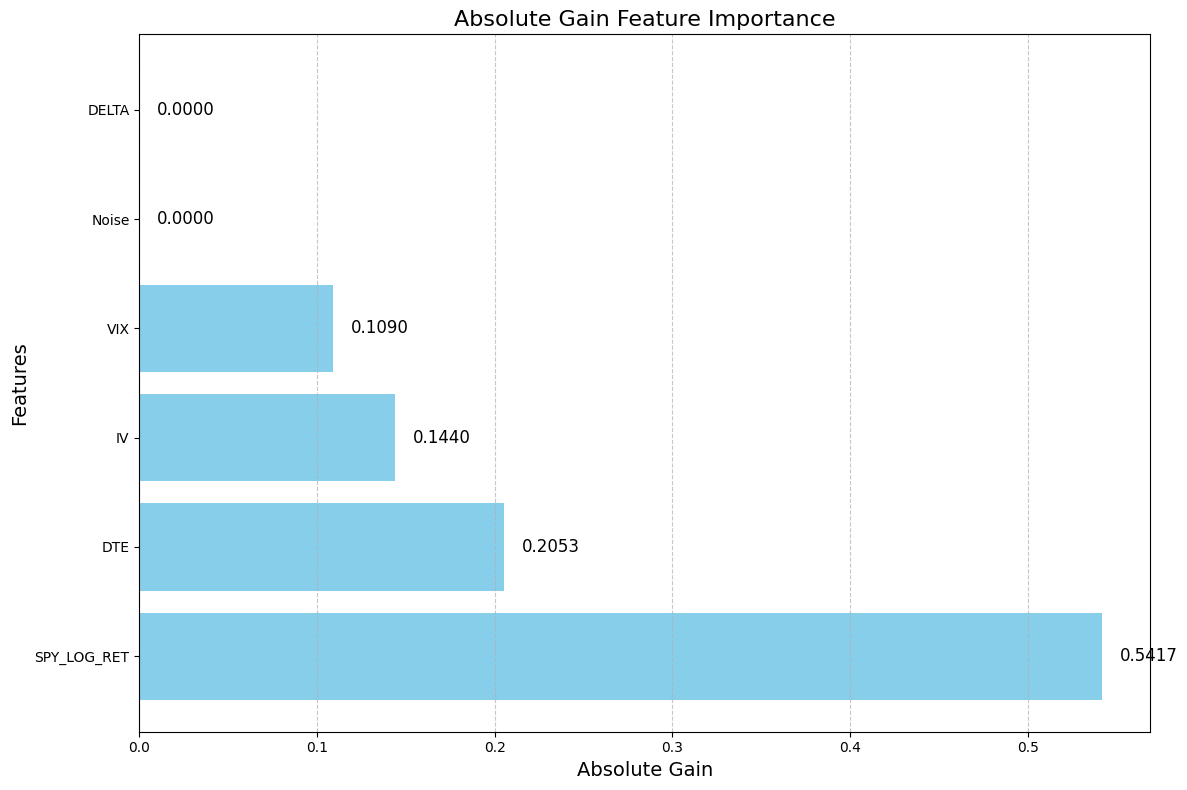

In [32]:
model5 = XGBRegressor(**best_params)

model5.fit(train[FACTORS_5_NOISE], train[TARGET])
train['xgb_noise'] = model5.predict(train[FACTORS_5_NOISE])
test['xgb_noise'] = model5.predict(test[FACTORS_5_NOISE])
valid['xgb_noise'] = model5.predict(valid[FACTORS_5_NOISE])

plot_importance(model5, FACTORS_5_NOISE)

### Test Set

In [38]:
print('=== MSE ===')
print('Benchmark:', mean_squared_error(test[TARGET], test['linear_pred']))
print('NN_2:', mean_squared_error(test[TARGET], test['nn_2factors']))
print('NN_3:', mean_squared_error(test[TARGET], test['nn_3factors']))
print('NN_4:', mean_squared_error(test[TARGET], test['nn_4factors']))
print('XGB_2:', mean_squared_error(test[TARGET], test['xgb2']))
print('XGB_3:', mean_squared_error(test[TARGET], test['xgb3']))
print('XGB_4:', mean_squared_error(test[TARGET], test['xgb4']))
print('XGB_5:', mean_squared_error(test[TARGET], test['xgb5']))
print('\n=== Gain over Benchmark ===')
print('NN_2:', calculate_gain(test, 'nn_2factors', 'linear_pred'))
print('NN_3:', calculate_gain(test, 'nn_3factors', 'linear_pred'))
print('NN_4:', calculate_gain(test, 'nn_4factors', 'linear_pred'))
print('XGB_2:', calculate_gain(test, 'xgb2', 'linear_pred'))
print('XGB_3:', calculate_gain(test, 'xgb3', 'linear_pred'))
print('XGB_4:', calculate_gain(test, 'xgb4', 'linear_pred'))
print('XGB_5:', calculate_gain(test, 'xgb5', 'linear_pred'))
print('\n=== R-Squared ===')
print('Benchmark:', r_square(test, 'linear_pred'))
print('NN_2:', r_square(test, 'nn_2factors'))
print('NN_3:', r_square(test, 'nn_3factors'))
print('NN_4:', r_square(test, 'nn_4factors'))
print('XGB_2:', r_square(test, 'xgb2'))
print('XGB_3:', r_square(test, 'xgb3'))
print('XGB_4:', r_square(test, 'xgb4'))
print('XGB_5:', r_square(test, 'xgb5'))

=== MSE ===
Benchmark: 8.9823156924106e-05
NN_2: 9.037207366749563e-05
NN_3: 8.923161204611769e-05
NN_4: 9.104148572746126e-05
XGB_2: 9.837229124328582e-05
XGB_3: 9.789344633369062e-05
XGB_4: 9.949134038751856e-05
XGB_5: 0.00010007129996205252

=== Gain over Benchmark ===
NN_2: -0.006111082733970541
NN_3: 0.006585661184098979
NN_4: -0.013563638209517226
XGB_2: -0.0951773975880541
XGB_3: -0.08984642363887763
XGB_4: -0.1076357566855668
XGB_5: -0.11409243884186182

=== R-Squared ===
Benchmark: 0.02176693989035594
NN_2: 0.015788876726920753
NN_3: 0.02820925138332242
NN_4: 0.008498540578439906
XGB_2: -0.07133873700547855
XGB_3: -0.06612380204581081
XGB_4: -0.08352591574938306
XGB_5: -0.08984205569329085


### Validation Set

In [40]:
print('=== MSE ===')
print('Benchmark:', mean_squared_error(valid[TARGET], valid['linear_pred']))
print('NN_2:', mean_squared_error(valid[TARGET], valid['nn_2factors']))
print('NN_3:', mean_squared_error(valid[TARGET], valid['nn_3factors']))
print('NN_4:', mean_squared_error(valid[TARGET], valid['nn_4factors']))
print('XGB_2:', mean_squared_error(valid[TARGET], valid['xgb2']))
print('XGB_3:', mean_squared_error(valid[TARGET], valid['xgb3']))
print('XGB_4:', mean_squared_error(valid[TARGET], valid['xgb4']))
print('XGB_5:', mean_squared_error(valid[TARGET], valid['xgb5']))
print('\n=== Gain over Benchmark ===')
print('NN_2:', calculate_gain(valid, 'nn_2factors', 'linear_pred'))
print('NN_3:', calculate_gain(valid, 'nn_3factors', 'linear_pred'))
print('NN_4:', calculate_gain(valid, 'nn_4factors', 'linear_pred'))
print('XGB_2:', calculate_gain(valid, 'xgb2', 'linear_pred'))
print('XGB_3:', calculate_gain(valid, 'xgb3', 'linear_pred'))
print('XGB_4:', calculate_gain(valid, 'xgb4', 'linear_pred'))
print('XGB_5:', calculate_gain(valid, 'xgb5', 'linear_pred'))
print('\n=== R-Squared ===')
print('Benchmark:', r_square(valid, 'linear_pred'))
print('NN_2', r_square(valid, 'nn_2factors'))
print('NN_3:', r_square(valid, 'nn_3factors'))
print('NN_4:', r_square(valid, 'nn_4factors'))
print('XGB_2:', r_square(valid, 'xgb2'))
print('XGB_3:', r_square(valid, 'xgb3'))
print('XGB_4:', r_square(valid, 'xgb4'))
print('XGB_5:', r_square(valid, 'xgb5'))

=== MSE ===
Benchmark: 8.243400108011296e-05
NN_2: 8.159715598180637e-05
NN_3: 8.116806262756494e-05
NN_4: 8.344503448476743e-05
XGB_2: 8.243546847672563e-05
XGB_3: 8.242894677783603e-05
XGB_4: 8.307523611821724e-05
XGB_5: 8.31922228843068e-05

=== Gain over Benchmark ===
NN_2: 0.010151698174801771
NN_3: 0.015356993909803385
NN_4: -0.012264762008481256
XGB_2: -1.7800866067840815e-05
XGB_3: 6.131331987657695e-05
XGB_4: -0.00777876882963735
XGB_5: -0.009197925543574792

=== R-Squared ===
Benchmark: 0.0025167550165288155
NN_2 0.01264290385402278
NN_3: 0.017835099134870913
NN_4: -0.009717139590641022
XGB_2: 0.002498998950879905
XGB_3: 0.0025779140257999877
XGB_4: -0.0052424365576342336
XGB_5: -0.006658021601792408


# Predicting Log Returns

In [77]:
TARGET = 'IV_LOG_RET'

In [42]:
# train = pd.read_pickle('our_approach_dataframes/train.pkl')
# test = pd.read_pickle('our_approach_dataframes/test.pkl')
# valid = pd.read_pickle('our_approach_dataframes/valid.pkl')

In [43]:
from torch import nn

params = {
    'depth': 2,
    'width': 30,
    'learning_rate': 0.00001,
    'batchnorm': False,
    'drop_out_rate': 0.05,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 15,
    'early_stopping_rounds': 3,
    'device': 'cpu',
    'scheduler_rate': 0.995
}


nn_4 = PytorchRegressor(**params)
nn_4.fit(train[FACTORS_2].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_2].to_numpy(), test[TARGET].to_numpy())])
train['nn2_logret'] = nn_4.predict(train[FACTORS_2].to_numpy())
test['nn2_logret'] = nn_4.predict(test[FACTORS_2].to_numpy())
valid['nn2_logret'] = nn_4.predict(valid[FACTORS_2 ].to_numpy())

Epoch_1 Train_loss: 0.018271841039301174, Val_loss: 0.003846060484647751
Epoch_2 Train_loss: 0.005832166140761477, Val_loss: 0.003068742575123906
Epoch_3 Train_loss: 0.004632066029596057, Val_loss: 0.0028235996142029762
Epoch_4 Train_loss: 0.0039836568596922015, Val_loss: 0.0027510481886565685
Epoch_5 Train_loss: 0.003617049789241328, Val_loss: 0.0027087898924946785
Epoch_6 Train_loss: 0.003385698186970908, Val_loss: 0.0026959467213600874
Epoch_7 Train_loss: 0.0032438551579692977, Val_loss: 0.002700720215216279
Epoch_8 Train_loss: 0.003139395001310605, Val_loss: 0.002690077992156148
Epoch_9 Train_loss: 0.0030714646999912324, Val_loss: 0.0026898181531578302
Epoch_10 Train_loss: 0.0030294704875852966, Val_loss: 0.0026844502426683903
Epoch_11 Train_loss: 0.0029999274011598505, Val_loss: 0.002683553844690323
Epoch_12 Train_loss: 0.0029801219494900565, Val_loss: 0.0026856756303459406
Epoch_13 Train_loss: 0.002965503881180825, Val_loss: 0.002684536390006542
Early stopping at epoch 14


In [44]:
from torch import nn

params = {
    'depth': 2,
    'width': 30,
    'learning_rate': 0.00001,
    'batchnorm': False,
    'drop_out_rate': 0.05,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 15,
    'early_stopping_rounds': 3,
    'device': 'cpu',
    'scheduler_rate': 0.995
}


nn_4 = PytorchRegressor(**params)
nn_4.fit(train[FACTORS_3].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_3].to_numpy(), test[TARGET].to_numpy())])
train['nn3_logret'] = nn_4.predict(train[FACTORS_3].to_numpy())
test['nn3_logret'] = nn_4.predict(test[FACTORS_3].to_numpy())
valid['nn3_logret'] = nn_4.predict(valid[FACTORS_3 ].to_numpy())

Epoch_1 Train_loss: 0.01214315320867663, Val_loss: 0.004332465119659901
Epoch_2 Train_loss: 0.0052299927212999696, Val_loss: 0.0031691989861428738
Epoch_3 Train_loss: 0.00413138950734296, Val_loss: 0.002892338903620839
Epoch_4 Train_loss: 0.0035911162211452316, Val_loss: 0.0027894088998436928
Epoch_5 Train_loss: 0.0033217719385007652, Val_loss: 0.0027361444663256407
Epoch_6 Train_loss: 0.003156209899250192, Val_loss: 0.0027135114651173353
Epoch_7 Train_loss: 0.0030680671165997093, Val_loss: 0.00270462385378778
Epoch_8 Train_loss: 0.003003998392590235, Val_loss: 0.0026958435773849487
Epoch_9 Train_loss: 0.002970110427531483, Val_loss: 0.0026976577937602997
Epoch_10 Train_loss: 0.0029441887990243236, Val_loss: 0.0026874965988099575
Epoch_11 Train_loss: 0.0029275683290493374, Val_loss: 0.002676224336028099
Epoch_12 Train_loss: 0.002914595363723832, Val_loss: 0.0026859489735215902
Epoch_13 Train_loss: 0.002907385754414146, Val_loss: 0.002677859738469124
Epoch_14 Train_loss: 0.0028998528537

In [78]:
from torch import nn

params = {
    'depth': 2,
    'width': 30,
    'learning_rate': 0.00001,
    'batchnorm': False,
    'drop_out_rate': 0.05,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 15,
    'early_stopping_rounds': 3,
    'device': 'cpu',
    'scheduler_rate': 0.995
}


nn_4 = PytorchRegressor(**params)
nn_4.fit(train[FACTORS_4].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_4].to_numpy(), test[TARGET].to_numpy())])
train['nn4_logret'] = nn_4.predict(train[FACTORS_4].to_numpy())
test['nn4_logret'] = nn_4.predict(test[FACTORS_4].to_numpy())
valid['nn4_logret'] = nn_4.predict(valid[FACTORS_4 ].to_numpy())

Epoch_1 Train_loss: 0.013540162003114293, Val_loss: 0.004601630847901106
Epoch_2 Train_loss: 0.005447252450489776, Val_loss: 0.0031695326324552298
Epoch_3 Train_loss: 0.004252093511572998, Val_loss: 0.002858534688130021
Epoch_4 Train_loss: 0.0037518921669132915, Val_loss: 0.002771886996924877
Epoch_5 Train_loss: 0.0034702688627921874, Val_loss: 0.002736411988735199
Epoch_6 Train_loss: 0.003312634389670908, Val_loss: 0.002706797793507576
Epoch_7 Train_loss: 0.0032086222215374667, Val_loss: 0.0026974857319146395
Epoch_8 Train_loss: 0.0031173521450253952, Val_loss: 0.002681577345356345
Epoch_9 Train_loss: 0.0030706769821839523, Val_loss: 0.0026774692814797163
Epoch_10 Train_loss: 0.0030220032061408315, Val_loss: 0.0026764406356960535
Epoch_11 Train_loss: 0.0029909843721809145, Val_loss: 0.002672538859769702
Epoch_12 Train_loss: 0.002962498413622809, Val_loss: 0.0026740655303001404
Epoch_13 Train_loss: 0.002945074949367066, Val_loss: 0.0026696869172155857
Epoch_14 Train_loss: 0.00293353348

In [79]:
from torch import nn

params = {
    'depth': 2,
    'width': 30,
    'learning_rate': 0.00001,
    'batchnorm': False,
    'drop_out_rate': 0.05,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 15,
    'early_stopping_rounds': 3,
    'device': 'cpu',
    'scheduler_rate': 0.995
}


nn_4 = PytorchRegressor(**params)
nn_4.fit(train[FACTORS_5].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_5].to_numpy(), test[TARGET].to_numpy())])
train['nn5_logret'] = nn_4.predict(train[FACTORS_5].to_numpy())
test['nn5_logret'] = nn_4.predict(test[FACTORS_5].to_numpy())
valid['nn5_logret'] = nn_4.predict(valid[FACTORS_5 ].to_numpy())

Epoch_1 Train_loss: 0.03176603780983465, Val_loss: 0.0041970182210206985
Epoch_2 Train_loss: 0.00547027578325861, Val_loss: 0.0031315358355641365
Epoch_3 Train_loss: 0.004306950134811708, Val_loss: 0.0029146315064281225
Epoch_4 Train_loss: 0.0037224279204786845, Val_loss: 0.002796966815367341
Epoch_5 Train_loss: 0.0033680173140800147, Val_loss: 0.002725741593167186
Epoch_6 Train_loss: 0.0031532681313192054, Val_loss: 0.0026837438344955444
Epoch_7 Train_loss: 0.003038895256630611, Val_loss: 0.002667068736627698
Epoch_8 Train_loss: 0.0029606033788116925, Val_loss: 0.002647140296176076
Epoch_9 Train_loss: 0.0029204491920325924, Val_loss: 0.0026333474088460207
Epoch_10 Train_loss: 0.002892928119044796, Val_loss: 0.0026332815177738667
Epoch_11 Train_loss: 0.0028736018425739125, Val_loss: 0.0026248586364090443
Epoch_12 Train_loss: 0.0028604313549208766, Val_loss: 0.0026227454654872417
Epoch_13 Train_loss: 0.0028525058710254262, Val_loss: 0.0026161137502640486
Epoch_14 Train_loss: 0.002845391

In [48]:
pruner = optuna.pruners.HyperbandPruner()
#pruner = optuna.pruners.NopPruner()

study = optuna.create_study(direction='minimize', pruner=pruner)
obj = Objective(pd.concat([train, test]), TARGET, FACTORS_4, 4)
study.optimize(obj, n_trials=40)

best = study.best_params
best['n_estimators'] = 300


[I 2024-05-30 22:21:09,351] A new study created in memory with name: no-name-f997606a-5e8c-4a33-8b9e-2a56f3f46e3a
[I 2024-05-30 22:21:15,992] Trial 0 finished with value: 0.003120026721007489 and parameters: {'colsample_bytree': 0.7571935160674038, 'learning_rate': 0.06674228358190006, 'max_depth': 23, 'subsample': 0.13197312389231572, 'gamma': 0.02673157564067019, 'reg_lambda': 7.315200585315364e-08, 'reg_alpha': 7.001637842083507e-07, 'min_child_weight': 18.827288505087303}. Best is trial 0 with value: 0.003120026721007489.


[0.00353311 0.00283199 0.00317027 0.00294474]


[I 2024-05-30 22:21:21,592] Trial 1 finished with value: 0.0028885144286081386 and parameters: {'colsample_bytree': 0.23221081938490987, 'learning_rate': 0.0025929014343813546, 'max_depth': 43, 'subsample': 0.32604054797067133, 'gamma': 0.5898504658470732, 'reg_lambda': 0.00491026701197568, 'reg_alpha': 0.07058223565410605, 'min_child_weight': 15.849661940212272}. Best is trial 1 with value: 0.0028885144286081386.


[0.0029919  0.00280167 0.00316336 0.00259713]


[I 2024-05-30 22:21:34,040] Trial 2 finished with value: 0.0029106532095872573 and parameters: {'colsample_bytree': 0.972482523646193, 'learning_rate': 5.3848276510660746e-05, 'max_depth': 27, 'subsample': 0.8238320152244705, 'gamma': 0.14835440430941327, 'reg_lambda': 3.241871857997026, 'reg_alpha': 1.1414080372662468e-08, 'min_child_weight': 38.564658662815134}. Best is trial 1 with value: 0.0028885144286081386.


[0.00302047 0.00283651 0.0031906  0.00259503]


[I 2024-05-30 22:21:39,243] Trial 3 finished with value: 0.0028728274514905018 and parameters: {'colsample_bytree': 0.6116745087652266, 'learning_rate': 0.011756575725702625, 'max_depth': 24, 'subsample': 0.30961991512414133, 'gamma': 0.9053535353933599, 'reg_lambda': 0.027616322273585285, 'reg_alpha': 6.840737498484723e-07, 'min_child_weight': 14.548510114361232}. Best is trial 3 with value: 0.0028728274514905018.


[0.002979   0.00277387 0.00311967 0.00261877]


[I 2024-05-30 22:21:43,234] Trial 4 pruned. 
[I 2024-05-30 22:21:48,521] Trial 5 pruned. 
[I 2024-05-30 22:21:55,417] Trial 6 pruned. 
[I 2024-05-30 22:22:03,090] Trial 7 finished with value: 0.002911222311428286 and parameters: {'colsample_bytree': 0.3521440583447838, 'learning_rate': 2.554621954050877e-05, 'max_depth': 37, 'subsample': 0.3921364171709053, 'gamma': 0.2746196510061041, 'reg_lambda': 0.000929279124379835, 'reg_alpha': 5.2493407914583635e-06, 'min_child_weight': 7.462801779565353}. Best is trial 3 with value: 0.0028728274514905018.


[0.00301776 0.00283869 0.00319358 0.00259487]


[I 2024-05-30 22:22:09,879] Trial 8 pruned. 
[I 2024-05-30 22:22:15,520] Trial 9 pruned. 
[I 2024-05-30 22:22:19,324] Trial 10 pruned. 
[I 2024-05-30 22:22:22,910] Trial 11 pruned. 
[I 2024-05-30 22:22:26,773] Trial 12 pruned. 
[I 2024-05-30 22:22:32,535] Trial 13 pruned. 
[I 2024-05-30 22:22:36,442] Trial 14 pruned. 
[I 2024-05-30 22:22:40,336] Trial 15 pruned. 
[I 2024-05-30 22:22:46,427] Trial 16 pruned. 
[I 2024-05-30 22:22:49,910] Trial 17 pruned. 
[I 2024-05-30 22:22:54,987] Trial 18 pruned. 
[I 2024-05-30 22:23:02,392] Trial 19 pruned. 
[I 2024-05-30 22:23:07,990] Trial 20 pruned. 
[I 2024-05-30 22:23:14,481] Trial 21 pruned. 
[I 2024-05-30 22:23:20,146] Trial 22 pruned. 
[I 2024-05-30 22:23:24,342] Trial 23 pruned. 
[I 2024-05-30 22:23:34,999] Trial 24 pruned. 
[I 2024-05-30 22:23:43,804] Trial 25 pruned. 
[I 2024-05-30 22:23:48,482] Trial 26 pruned. 
[I 2024-05-30 22:23:53,826] Trial 27 pruned. 
[I 2024-05-30 22:24:00,045] Trial 28 pruned. 
[I 2024-05-30 22:24:06,285] Trial 29

[0.00301747 0.00283868 0.00319344 0.00259482]


[I 2024-05-30 22:24:33,320] Trial 30 pruned. 
[I 2024-05-30 22:24:37,107] Trial 31 pruned. 
[I 2024-05-30 22:24:40,670] Trial 32 pruned. 
[I 2024-05-30 22:24:47,278] Trial 33 finished with value: 0.002910943253442965 and parameters: {'colsample_bytree': 0.9341759993510521, 'learning_rate': 1.9039767295119855e-05, 'max_depth': 6, 'subsample': 0.19657222593901064, 'gamma': 0.9225787290461747, 'reg_lambda': 1.986905526085388e-06, 'reg_alpha': 5.561379133560509e-08, 'min_child_weight': 22.75482182047309}. Best is trial 3 with value: 0.0028728274514905018.


[0.00301726 0.00283846 0.00319325 0.0025948 ]


[I 2024-05-30 22:24:50,963] Trial 34 pruned. 
[I 2024-05-30 22:24:57,024] Trial 35 pruned. 
[I 2024-05-30 22:25:01,379] Trial 36 pruned. 
[I 2024-05-30 22:25:06,675] Trial 37 pruned. 
[I 2024-05-30 22:25:09,764] Trial 38 pruned. 
[I 2024-05-30 22:25:16,242] Trial 39 pruned. 


In [49]:
model5 = XGBRegressor(**best)

model5.fit(train[FACTORS_2], train[TARGET])
train['xgb2_logret'] = model5.predict(train[FACTORS_2])
test['xgb2_logret'] = model5.predict(test[FACTORS_2])
valid['xgb2_logret'] = model5.predict(valid[FACTORS_2])

model5 = XGBRegressor(**best)

model5.fit(train[FACTORS_3], train[TARGET])
train['xgb3_logret'] = model5.predict(train[FACTORS_3])
test['xgb3_logret'] = model5.predict(test[FACTORS_3])
valid['xgb3_logret'] = model5.predict(valid[FACTORS_3])

model5 = XGBRegressor(**best)

model5.fit(train[FACTORS_4], train[TARGET])
train['xgb4_logret'] = model5.predict(train[FACTORS_4])
test['xgb4_logret'] = model5.predict(test[FACTORS_4])
valid['xgb4_logret'] = model5.predict(valid[FACTORS_4])

model5 = XGBRegressor(**best)

model5.fit(train[FACTORS_5], train[TARGET])
train['xgb5_logret'] = model5.predict(train[FACTORS_5])
test['xgb5_logret'] = model5.predict(test[FACTORS_5])
valid['xgb5_logret'] = model5.predict(valid[FACTORS_5])

# Predicting Binary Movements

In [50]:
TARGET = 'y_binary'

In [51]:
def add_classification_targets(dataset: pd.DataFrame):
    dataset['y_binary'] = (dataset['IV_LOG_RET'] > 0).astype(int)
    dataset['weight'] = dataset['IV_LOG_RET'].abs()
    
    return dataset

In [52]:
train = add_classification_targets(train)
test = add_classification_targets(test)
valid = add_classification_targets(valid)

In [53]:
from sklearn.metrics import accuracy_score

In [54]:
def calculate_weighted_accuracy(dataset: pd.DataFrame, target_col: str, regression=True):
    
    if regression:
        pred = (dataset[target_col] > 0).astype(int)
    else: 
        pred = (dataset[target_col] > 0.5).astype(int)
            
    return accuracy_score(dataset['y_binary'], pred, sample_weight=dataset['weight'])
    

In [55]:
from torch import nn

params = {
    'depth': 2,
    'width': 30,
    'learning_rate': 0.00001,
    'batchnorm': False,
    'drop_out_rate': 0.05,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 15,
    'early_stopping_rounds': 3,
    'device': 'cpu',
    'scheduler_rate': 0.995,
    'classification': True,
}


nn_4 = PytorchRegressor(**params)
nn_4.fit(train[FACTORS_2].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_2].to_numpy(), test[TARGET].to_numpy())])
train['nn2_binary'] = nn_4.predict(train[FACTORS_2].to_numpy())
test['nn2_binary'] = nn_4.predict(test[FACTORS_2].to_numpy())
valid['nn2_binary'] = nn_4.predict(valid[FACTORS_2].to_numpy())

Epoch_1 Train_loss: 0.6934403873729027, Val_loss: 0.6891818642616272
Epoch_2 Train_loss: 0.6904682330997024, Val_loss: 0.6881126761436462
Epoch_3 Train_loss: 0.6899229254083028, Val_loss: 0.6879683136940002
Epoch_4 Train_loss: 0.6895828091359592, Val_loss: 0.6879271864891052
Epoch_5 Train_loss: 0.6896267426369965, Val_loss: 0.687945544719696
Epoch_6 Train_loss: 0.6895204060692655, Val_loss: 0.687947690486908
Early stopping at epoch 7


In [56]:
from torch import nn

params = {
    'depth': 2,
    'width': 30,
    'learning_rate': 0.00001,
    'batchnorm': False,
    'drop_out_rate': 0.05,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 15,
    'early_stopping_rounds': 3,
    'device': 'cpu',
    'scheduler_rate': 0.995,
    'classification': True,
}


nn_4 = PytorchRegressor(**params)
nn_4.fit(train[FACTORS_3].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_3].to_numpy(), test[TARGET].to_numpy())])
train['nn3_binary'] = nn_4.predict(train[FACTORS_3].to_numpy())
test['nn3_binary'] = nn_4.predict(test[FACTORS_3].to_numpy())
valid['nn3_binary'] = nn_4.predict(valid[FACTORS_3].to_numpy())

Epoch_1 Train_loss: 0.6993625902802699, Val_loss: 0.6914934515953064
Epoch_2 Train_loss: 0.6918870318340107, Val_loss: 0.6885483860969543
Epoch_3 Train_loss: 0.6901151940221804, Val_loss: 0.687693178653717
Epoch_4 Train_loss: 0.6895908001366476, Val_loss: 0.6873573064804077
Epoch_5 Train_loss: 0.6893054687998376, Val_loss: 0.6871848106384277
Epoch_6 Train_loss: 0.6891760353087264, Val_loss: 0.6870728731155396
Epoch_7 Train_loss: 0.6890911259171255, Val_loss: 0.6869911551475525
Epoch_8 Train_loss: 0.689074075238486, Val_loss: 0.6869284510612488
Epoch_9 Train_loss: 0.6890048008692836, Val_loss: 0.6868876814842224
Epoch_10 Train_loss: 0.6889473233672483, Val_loss: 0.6868658661842346
Epoch_11 Train_loss: 0.6889366765675528, Val_loss: 0.6868487000465393
Epoch_12 Train_loss: 0.6889141421095574, Val_loss: 0.68681401014328
Epoch_13 Train_loss: 0.6888131570874321, Val_loss: 0.6867983937263489
Epoch_14 Train_loss: 0.6888644253552587, Val_loss: 0.6867888569831848
Epoch_15 Train_loss: 0.6888160302

In [58]:
from torch import nn

params = {
    'depth': 2,
    'width': 30,
    'learning_rate': 0.00001,
    'batchnorm': False,
    'drop_out_rate': 0.05,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 15,
    'early_stopping_rounds': 3,
    'device': 'cpu',
    'scheduler_rate': 0.995,
    'classification': True,
}


nn_4 = PytorchRegressor(**params)
nn_4.fit(train[FACTORS_4].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_4].to_numpy(), test[TARGET].to_numpy())])
train['nn4_binary'] = nn_4.predict(train[FACTORS_4].to_numpy())
test['nn4_binary'] = nn_4.predict(test[FACTORS_4].to_numpy())
valid['nn4_binary'] = nn_4.predict(valid[FACTORS_4 ].to_numpy())

Epoch_1 Train_loss: 0.6929767071370909, Val_loss: 0.689149022102356
Epoch_2 Train_loss: 0.6878450201464607, Val_loss: 0.6877522468566895
Epoch_3 Train_loss: 0.6859490028133629, Val_loss: 0.687273383140564
Epoch_4 Train_loss: 0.6853766120294795, Val_loss: 0.6870520710945129
Epoch_5 Train_loss: 0.6847843017458016, Val_loss: 0.6868841052055359
Epoch_6 Train_loss: 0.684661973154954, Val_loss: 0.6867405772209167
Epoch_7 Train_loss: 0.6843689354297927, Val_loss: 0.6866160035133362
Epoch_8 Train_loss: 0.6843662830579419, Val_loss: 0.6865044236183167
Epoch_9 Train_loss: 0.68411812007915, Val_loss: 0.6863572001457214
Epoch_10 Train_loss: 0.684129659301455, Val_loss: 0.6862452626228333
Epoch_11 Train_loss: 0.6839851001925898, Val_loss: 0.6861152648925781
Epoch_12 Train_loss: 0.6839313341170242, Val_loss: 0.6860023736953735
Epoch_13 Train_loss: 0.6838433680251574, Val_loss: 0.6859042048454285
Epoch_14 Train_loss: 0.683772088009387, Val_loss: 0.6857972145080566
Epoch_15 Train_loss: 0.6837235014311

In [59]:
from torch import nn

params = {
    'depth': 2,
    'width': 30,
    'learning_rate': 0.00001,
    'batchnorm': False,
    'drop_out_rate': 0.05,
    'batch_size': 512,
    'activation_fn': nn.ReLU,
    'n_epochs': 15,
    'early_stopping_rounds': 3,
    'device': 'cpu',
    'scheduler_rate': 0.995,
    'classification': True,
}


nn_6 = PytorchRegressor(**params)
nn_6.fit(train[FACTORS_5].to_numpy(), train[TARGET].to_numpy(), eval_set=[(test[FACTORS_5].to_numpy(), test[TARGET].to_numpy())])
train['nn5_binary'] = nn_6.predict(train[FACTORS_5].to_numpy())
test['nn5_binary'] = nn_6.predict(test[FACTORS_5].to_numpy())
valid['nn5_binary'] = nn_6.predict(valid[FACTORS_5].to_numpy())

Epoch_1 Train_loss: 0.6956354940668634, Val_loss: 0.6914111375808716
Epoch_2 Train_loss: 0.6880456153499369, Val_loss: 0.689624011516571
Epoch_3 Train_loss: 0.6867862158113566, Val_loss: 0.6887753009796143
Epoch_4 Train_loss: 0.6860593157628477, Val_loss: 0.6880951523780823
Epoch_5 Train_loss: 0.6854824142839187, Val_loss: 0.6874815225601196
Epoch_6 Train_loss: 0.6849873329985217, Val_loss: 0.6869449019432068
Epoch_7 Train_loss: 0.6846208353835219, Val_loss: 0.6864444017410278
Epoch_8 Train_loss: 0.68414912833609, Val_loss: 0.6859721541404724
Epoch_9 Train_loss: 0.6837760661775697, Val_loss: 0.685541570186615
Epoch_10 Train_loss: 0.683410951987072, Val_loss: 0.6851646304130554
Epoch_11 Train_loss: 0.68308886439986, Val_loss: 0.6848376989364624
Epoch_12 Train_loss: 0.6827424138432824, Val_loss: 0.6845484375953674
Epoch_13 Train_loss: 0.6826297899769322, Val_loss: 0.6843234300613403
Epoch_14 Train_loss: 0.6823040868412715, Val_loss: 0.684088408946991
Epoch_15 Train_loss: 0.68216910107202

In [60]:
# pruner = optuna.pruners.HyperbandPruner()
# #pruner = optuna.pruners.NopPruner()

# study = optuna.create_study(direction='minimize', pruner=pruner)
# obj = Objective(pd.concat([train, test]), TARGET, FACTORS_4, 4, classification=True)
# study.optimize(obj, n_trials=100)

# best = study.best_params
# best['n_estimators'] = 300

In [61]:
from sklearn.ensemble import ExtraTreesClassifier

In [62]:
best = {'n_estimators': 300,'colsample_bytree': 0.9935943086961306, 'learning_rate': 0.0016435480543948394, 'max_depth': 5, 'subsample': 0.8857895396939933, 
        'gamma': 0.40093131276578453, 'reg_lambda': 0.002588041476387973, 'reg_alpha': 1.2482866363895047e-05, 'min_child_weight': 15.369710038841857}


In [63]:
model5 = XGBClassifier(**best)

model5.fit(train[FACTORS_2], train[TARGET])
train['xgb2_binary'] = model5.predict(train[FACTORS_2])
test['xgb2_binary'] = model5.predict(test[FACTORS_2])
valid['xgb2_binary'] = model5.predict(valid[FACTORS_2])


model5 = XGBClassifier(**best)

model5.fit(train[FACTORS_3], train[TARGET])
train['xgb3_binary'] = model5.predict(train[FACTORS_3])
test['xgb3_binary'] = model5.predict(test[FACTORS_3])
valid['xgb3_binary'] = model5.predict(valid[FACTORS_3])

model5 = XGBClassifier(**best)

model5.fit(train[FACTORS_4], train[TARGET])
train['xgb4_binary'] = model5.predict(train[FACTORS_4])
test['xgb4_binary'] = model5.predict(test[FACTORS_4])
valid['xgb4_binary'] = model5.predict(valid[FACTORS_4])

model5 = XGBClassifier(**best)

model5.fit(train[FACTORS_5], train[TARGET])
train['xgb5_binary'] = model5.predict(train[FACTORS_5])
test['xgb5_binary'] = model5.predict(test[FACTORS_5])
valid['xgb5_binary'] = model5.predict(valid[FACTORS_5])

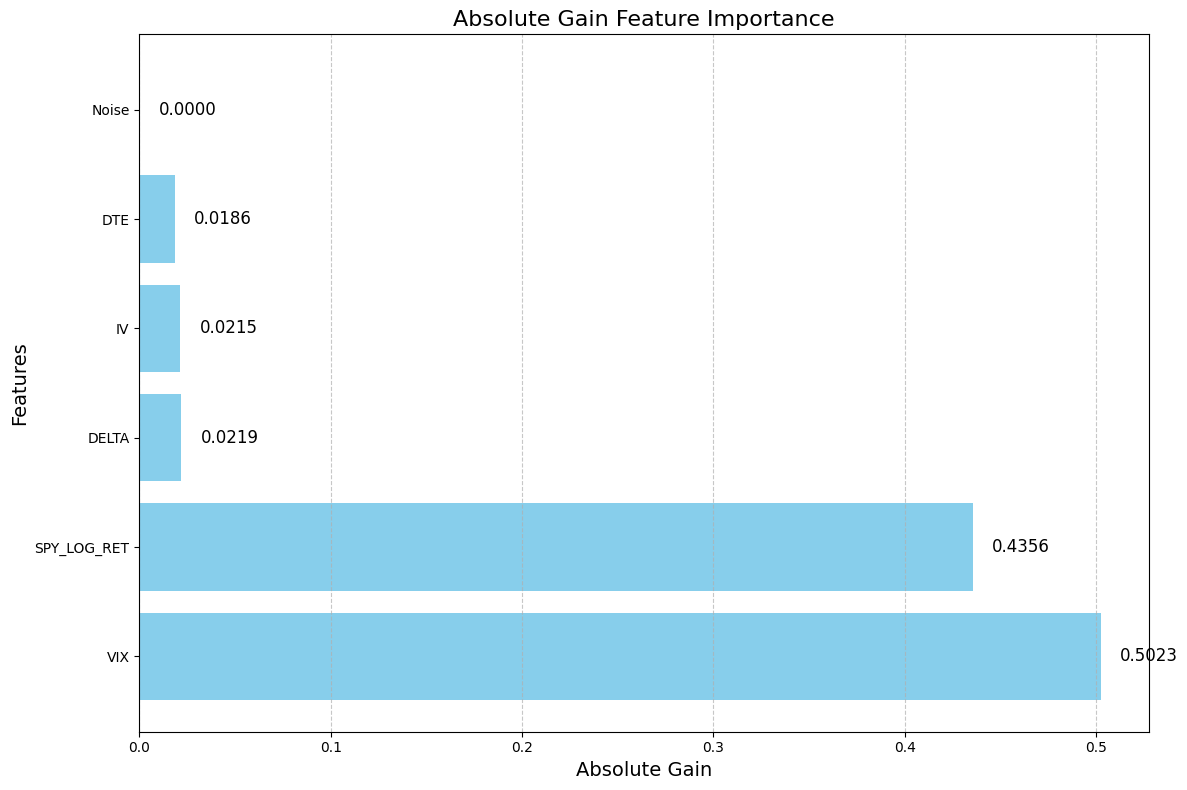

In [64]:
model5 = XGBRegressor(**best)

model5.fit(train[FACTORS_5_NOISE], train[TARGET])
train['xgb_noise'] = model5.predict(train[FACTORS_5_NOISE])
test['xgb_noise'] = model5.predict(test[FACTORS_5_NOISE])
valid['xgb_noise'] = model5.predict(valid[FACTORS_5_NOISE])

plot_importance(model5, FACTORS_5_NOISE)

# Results

In [65]:
# baseline accuracy:
accuracy_score(valid['y_binary'], np.zeros(len(valid)), sample_weight=valid['weight'])

0.5209596415045112

In [66]:
def is_regression(series: pd.Series) -> bool:

    # Check if all values are within the range [0, 1]
    if series.between(0, 1).all() or set(series.unique()) == {0, 1}:
        return False
    else:
        return True

In [80]:
train.columns

Index(['QUOTE_DATE', 'option_id', 'EXPIRE_UNIX', 'STRIKE', 'IV', 'DELTA',
       'DTE', 'MID', 'UNDERLYING_LAST', 'BidAskSpread', 'VOLUME', 'IV_DELTA',
       'IV_LOG_RET', 'VIX', '1Y_US', 'SPY_LOG_RET', 'Noise', 'linear_pred',
       'nn_2factors', 'nn_3factors', 'nn_4factors', 'nn_5factors', 'xgb2',
       'xgb3', 'xgb4', 'xgb5', 'xgb_noise', 'nn2_logret', 'nn3_logret',
       'nn4_logret', 'xgb2_logret', 'xgb3_logret', 'xgb4_logret',
       'xgb5_logret', 'y_binary', 'weight', 'nn2_binary', 'nn3_binary',
       'nn4_binary', 'nn5_binary', 'xgb2_binary', 'xgb3_binary', 'xgb4_binary',
       'xgb5_binary', 'nn5_logret'],
      dtype='object')

In [81]:
models = ['linear_pred', 'nn_2factors', 'nn_3factors', 'nn_4factors', 'nn_5factors', 'xgb2',
          'xgb3', 'xgb4', 'xgb5', 'xgb_noise', 'nn2_logret', 'nn3_logret', 
          'nn4_logret', 'nn5_logret', 'xgb2_logret', 'xgb3_logret', 'xgb4_logret',
          'xgb5_logret', 'nn2_binary', 'nn3_binary',
          'nn4_binary', 'nn5_binary', 'xgb2_binary', 'xgb3_binary', 'xgb4_binary',
          'xgb5_binary']

In [82]:
scores = {}
for m in models:
    
    regression = is_regression(valid[m])
    
    scores[m] = calculate_weighted_accuracy(valid, m , regression)    

In [86]:
scores

{'linear_pred': 0.5594273261625322,
 'nn_2factors': 0.5677790230832834,
 'nn_3factors': 0.5468627782908508,
 'nn_4factors': 0.5703873946226954,
 'nn_5factors': 0.5589892278154506,
 'xgb2': 0.4807073180271663,
 'xgb3': 0.4807073180271663,
 'xgb4': 0.4772158021953438,
 'xgb5': 0.47853351186024556,
 'xgb_noise': 0.6105546849075772,
 'nn2_logret': 0.5535630317570364,
 'nn3_logret': 0.5574581841416199,
 'nn4_logret': 0.5649604052246757,
 'nn5_logret': 0.5735901615678556,
 'xgb2_logret': 0.5441507154020446,
 'xgb3_logret': 0.5377078438847362,
 'xgb4_logret': 0.5049304014146231,
 'xgb5_logret': 0.5014649948850787,
 'nn2_binary': 0.55808960981304,
 'nn3_binary': 0.5532601021756832,
 'nn4_binary': 0.574590184707517,
 'nn5_binary': 0.5798937443544794,
 'xgb2_binary': 0.5724828565308957,
 'xgb3_binary': 0.5941181250153774,
 'xgb4_binary': 0.6191101416372047,
 'xgb5_binary': 0.6157958847423932}

In [84]:
train

,QUOTE_DATE,option_id,EXPIRE_UNIX,STRIKE,IV,DELTA,DTE,MID,UNDERLYING_LAST,BidAskSpread,...,weight,nn2_binary,nn3_binary,nn4_binary,nn5_binary,xgb2_binary,xgb3_binary,xgb4_binary,xgb5_binary,nn5_logret
33736,2011-12-14,C_20120120_112.0,1327093200,112.0,2.342395,1.700603,-0.637479,10.330,121.74,0.011617,...,0.082371,0.502228,0.508230,0.422476,0.423597,0,0,0,0,-0.004951
33794,2011-12-14,C_20120120_113.0,1327093200,113.0,2.285448,1.553686,-0.637479,9.500,121.74,0.014737,...,0.071411,0.498240,0.501703,0.421213,0.422817,0,0,0,0,-0.005970
36610,2011-12-14,C_20120217_108.0,1329512400,108.0,3.069698,1.644867,-0.475281,14.880,121.74,0.013441,...,0.052287,0.500715,0.509061,0.422411,0.394646,0,0,0,0,-0.013124
36631,2011-12-14,C_20120217_110.0,1329512400,110.0,2.938661,1.469543,-0.475281,13.225,121.74,0.015879,...,0.051606,0.495837,0.501476,0.421052,0.396024,0,0,0,0,-0.013474
36648,2011-12-14,C_20120217_111.0,1329512400,111.0,2.798954,1.380520,-0.475281,12.375,121.74,0.012121,...,0.039855,0.493261,0.497578,0.420362,0.399774,0,0,0,0,-0.013332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54414,2010-02-22,C_20121221_115.0,1356123600,115.0,0.871827,-0.051201,5.132132,12.485,111.13,0.021626,...,0.003001,0.506217,0.500566,0.450281,0.479165,1,1,0,0,0.001812
54692,2010-02-22,C_20121221_120.0,1356123600,120.0,0.780397,-0.327466,5.132132,10.370,111.13,0.023144,...,0.002931,0.493099,0.501914,0.448050,0.472411,1,1,0,0,0.001286
55105,2010-02-22,C_20121221_125.0,1356123600,125.0,0.649360,-0.606197,5.132132,8.410,111.13,0.030916,...,0.001283,0.487712,0.503317,0.445800,0.465781,1,1,0,0,0.001053
58501,2010-02-22,C_20121221_150.0,1356123600,150.0,0.150238,-1.803569,5.132132,2.320,111.13,0.051724,...,0.005350,0.467894,0.514397,0.436691,0.441673,1,1,0,0,-0.000858


In [85]:
train.to_pickle('our_approach_dataframes/train.pkl')
test.to_pickle('our_approach_dataframes/test.pkl')
valid.to_pickle('our_approach_dataframes/valid.pkl')